In [1]:
# This work aims to develop a reduced order model using POD LSTM method using snapshot CFD data. This works attempts to do this for cavity with thermal boundary conditions.
# The code here involves modifications of similar works referenced below to suit my problem.
# Similar work has been done by follwing researchers. 
# References to follow for the work
    # LSTM + POD : https://github.com/surajp92/NIROM_SST/blob/main/example_noaa.py
    # ACE VS PCA : https://github.com/llabhishekll/blog-PCA-using-autoencoder
    # LSTM + POD : https://github.com/arvindmohan/LSTM_ROM_Arxiv/blob/master/analysis/ISO/BuildROMfromLSTM.ipynb
    # NeuralODE + ACE + LSTM :  https://github.com/CarlosJose126/NeuralODE-ROM/blob/main/VKS_lstm.py and 
    #                           https://github.com/CarlosJose126/NeuralODE-ROM
    # ACE + LSTM :  https://github.com/Romit-Maulik/CAE_LSTM_ROMS/blob/main/Burgers_Equations/AE_LSTM_MP.ipynb
    #               and and https://github.com/Romit-Maulik/POD_LSTM_DayMet/blob/master/src/ML_Time.py  

                     


In [48]:
from __future__ import print_function, division
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
import matplotlib.cm as cm
import scipy.interpolate


import random
random.seed(10)

import numpy as np
np.random.seed(10)

import tensorflow as tf
tf.random.set_seed(0)

import time as tm

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import matplotlib.animation as animation

%config Completer.use_jedi = False
%matplotlib inline
#%matplotlib notebook
#%matplotlib tk
import os
import pandas as pd
import matplotlib.pyplot as plt


import numpy as np
    #import copy
    #import pandas as pd
    #import matplotlib.dates as mdates
    #from matplotlib.dates import DateFormatter
    #import matplotlib.pyplot as plt
    #import mplcursors
    #import time as tm
    #import os

    #import datetime
    #import matplotlib.pyplot as plt
    #import matplotlib.dates as mdates
    #from matplotlib.dates import DateFormatter
    #import numpy as np


import sys 
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras


#import sklearn.decomposition
#import sklearn.preprocessing
#print(sklearn.__version__)

import matplotlib.pyplot as plt

#Optuna
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

# For LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

#from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

import sys


#plt.style.use('plot_style.txt')

font = {'family' : 'Times New Roman',
        'size'   : 16}    
plt.rc('font', **font)

#'weight' : 'bold'

import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

import h5py
from tqdm import tqdm as tqdm


2.6.0


In [3]:
# provide path name to where the files are stored.
path_filename='C:/Users/mandart/Downloads/asciifilesforbothsideheatedcavity/Laminar_case_all_ASCII_files'

In [4]:
#load all the files starting with "prefix"  data. Input Data is in form for each timestep - there is spatial coordinates x,y and variable value." below.
# Load data. Input Data is in form for each timestep - there is spatial coordinates x,y and variable value.
import os
import re

prefix='iisc'

direcU=[x for x in os.listdir(path_filename) if x.startswith(prefix)] #list all files in path and selects those starting with prefix

# Sort the filenames based on number in file name and Create a list with file names sorted based on the number in the file name.
direcUsorted = sorted(direcU, key=lambda f: int(re.findall('\d+', f)[0])) 

del direcU #save memory by deleting.



In [5]:
# for pcs, data in format of num_snapshot x num_spatial resolution

b['velocity-magnitude']
b['temperature']

In [6]:
# 
# Now store spatial coordinates of grid
a=pd.read_csv(path_filename+'/'+direcUsorted[0],delimiter=r"\s+") #
x=a['x-coordinate']
y=a['y-coordinate']
xis = np.linspace(min(x), max(x))
yis = np.linspace(min(y), max(y))

xi, yi = np.meshgrid(xis,yis)

In [8]:
#listU=[]
#listT=[]
listU=np.array([])
listT=np.array([])
import pandas as pd
count=0
for file1 in direcUsorted: #zip enables parallel iteration
            #print(file1,file2,file3) #file_names and load contents of file name into list below. 
       
    a=pd.read_csv(path_filename+'/'+file1,delimiter=r"\s+") #direcUsorted[0]
    if a.isnull().sum().sum():
        print("All bad")
    b=a.dropna()
    if count==0:                 
        listU=b['velocity-magnitude']
        listT=b['temperature']
    else:
        listU=np.vstack((listU,b['velocity-magnitude']))
        listT=np.vstack((listT,b['temperature']))
        
    
    #listT.hstack(b['temperature'])
    
    #a=pd.read_csv(path_filename+'/'+file1)
    #print(a.head())
    
    del b,a
    #print(count)
    #print(listU.shape)
    count=count+1
     #if count>1: #open this for checking the code
      #  break
        
    
    

x=a['x-coordinate']
y=a['y-coordinate']

In [9]:
print(listU.shape)
listT.shape

(350, 3561)


(350, 3561)

In [10]:
# Data  shape in format needed by POD > ie num_of_grids x num_snapshots
U=listU.T
T=listT.T

In [11]:
###############################################################################
#POD Routines
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u





In [12]:
# Do Singular value decomposition of data X to obtain basis functions , X=USV.T. Here data is velocity and temperature.
from numpy import linalg as LA
Phi_U,L_U,RIC_U=POD(U,10)

In [13]:
Phi_T,L_T,RIC_T=POD(T,10)

In [14]:
pd.DataFrame(T).describe()

,0,1,2,3,4,5,6,7,8,9,...,340,341,342,343,344,345,346,347,348,349
count,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,...,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000
mean,300.379163,300.423880,300.455661,300.499840,300.540378,300.583035,300.623874,300.665800,300.706917,300.749181,...,311.150396,311.171346,311.193658,311.212938,311.236898,311.254909,311.278327,311.296503,311.318100,311.340774
std,0.635588,0.656549,0.672301,0.694788,0.711258,0.731382,0.746962,0.763296,0.777796,0.793249,...,0.657214,0.653692,0.653401,0.655435,0.655952,0.652035,0.651607,0.652926,0.656368,0.651207
min,299.999451,299.999695,299.999725,299.999725,299.999756,299.999817,299.999847,299.999847,299.999847,299.999878,...,308.576080,308.369873,308.530273,308.658051,308.443542,308.636871,308.864502,308.622070,308.471405,308.520233
25%,300.000061,300.000061,300.000183,300.000275,300.000916,300.004578,300.012390,300.022400,300.039124,300.060547,...,310.825714,310.845215,310.865784,310.885590,310.908142,310.934662,310.948364,310.978760,310.992126,311.013458
50%,300.005279,300.032288,300.060883,300.119293,300.169617,300.230927,300.286102,300.353149,300.410614,300.464294,...,311.040710,311.063629,311.082825,311.097137,311.119873,311.145386,311.170898,311.183777,311.209595,311.230469
75%,300.498138,300.643860,300.722290,300.826263,300.903503,301.000275,301.065979,301.141968,301.214203,301.278229,...,311.189606,311.206024,311.226654,311.253662,311.272888,311.277924,311.306488,311.320312,311.347260,311.373810
max,303.054626,303.156342,303.233490,303.369171,303.447174,303.555023,303.623718,303.703613,303.768616,303.843048,...,313.823975,313.834595,313.855743,313.881958,313.910461,313.910889,313.949493,313.956085,313.984894,314.000732


In [155]:
# Cumulative Energy with Modes and plot below 
cumsum_T=np.cumsum(L_T[:10])/sum(L_T)*100 
Tcumsum=np.around(cumsum_T, 6) 

In [16]:
np.cumsum(L_U[:10])/sum(L_U)*100

array([97.33328931, 98.70398079, 99.48657792, 99.65646186, 99.72697398,
       99.78444112, 99.82183285, 99.84657492, 99.86917418, 99.88813435])

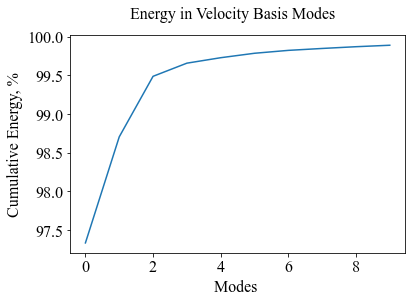

In [141]:
fig = plt.figure()
plt.plot(np.cumsum(L_U[:10])/sum(L_U)*100)
fig.suptitle('Energy in Velocity Basis Modes', fontsize=16)
plt.xlabel('Modes ', fontsize=16)
plt.ylabel('Cumulative Energy, %', fontsize=16)
fig.savefig('Cumulative_Energy_Velocity.jpg')




In [156]:
Tcumsum

array([ 99.999918,  99.999985,  99.999999, 100.      , 100.      ,
       100.      , 100.      , 100.      , 100.      , 100.      ])

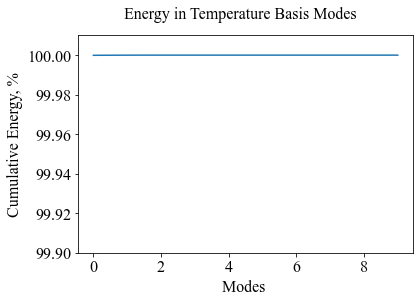

In [162]:
fig = plt.figure()
plt.plot(Tcumsum)
fig.suptitle('Energy in Temperature Basis Modes', fontsize=16)
plt.xlabel('Modes ', fontsize=16)
plt.ylabel('Cumulative Energy, %', fontsize=16)
plt.ylim((99.9,100.01))
fig.savefig('Cumulative_Energy_Temperature.jpg')

In [17]:
#Obtain coefficients by projecting the original dataset into Basis function coordinates 

a_true_4_U=PODproj(U,Phi_U)
a_true_4_T=PODproj(T,Phi_T)


In [18]:
pd.DataFrame(Phi_T).describe()

,0,1,2,3,4,5,6,7,8,9
count,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000,3561.000000
mean,-0.016758,0.000028,-0.000009,-0.000001,0.000003,0.000005,-0.000004,0.000004,-0.000002,0.000001
std,0.000044,0.016760,0.016760,0.016760,0.016760,0.016760,0.016760,0.016760,0.016760,0.016760
min,-0.016917,-0.057828,-0.072517,-0.100617,-0.076160,-0.124316,-0.124100,-0.197590,-0.199975,-0.280509
25%,-0.016778,-0.013352,-0.010151,-0.012338,-0.011774,-0.006994,-0.006775,-0.003260,-0.003485,-0.001769
50%,-0.016759,-0.001481,0.004901,0.002544,-0.001257,0.000620,0.000187,0.000580,-0.000257,-0.000189
75%,-0.016730,0.014813,0.013370,0.013329,0.012649,0.008697,0.005384,0.004175,0.002641,0.001957
max,-0.016672,0.026498,0.019457,0.027521,0.109193,0.141807,0.137759,0.210370,0.268511,0.176660


In [19]:
R=a_true_4_U.shape #number_snapshots x num_modes temporal coefficients. 

t=[0]
deltaT=1
for x in range(0, R[0], 50):
    b1=[t[0]+x*deltaT]
       
    t.append(b1)
    
    

In [20]:
# create plots folder
if os.path.isdir("./Plots1"):
    print('Plots folder already exists')
else: 
    print('Creating plots folder')
    os.makedirs("./Plots1")

Plots folder already exists


In [21]:
Phi_U.shape

(3561, 10)

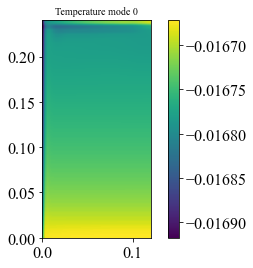

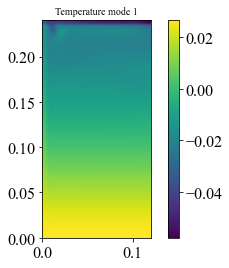

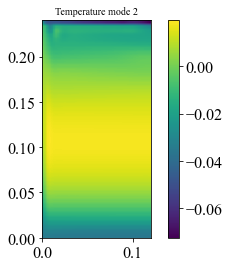

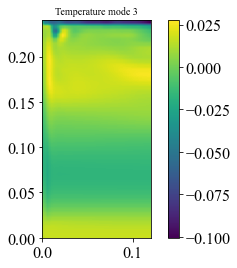

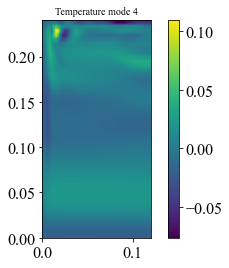

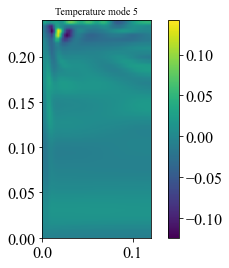

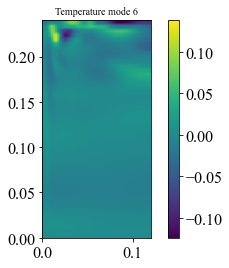

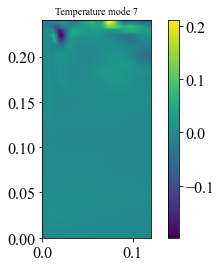

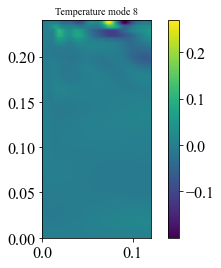

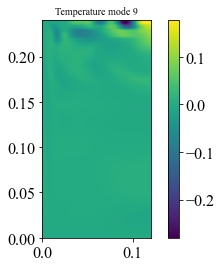

In [22]:
#Plot contour plots using imshow. You can include cbar in imshow to choose colorbar. 
for i in range(Phi_T.shape[1]):
    
    plt.figure(i,facecolor=(1, 1, 1))
    v=Phi_T[:,i]
    zi = scipy.interpolate.griddata((x,y),v,(xi,yi),method="cubic")
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'
    plt.imshow(zi, vmin=v.min(), vmax=v.max(), origin="lower", extent=[x.min(), x.max(), y.min(), y.max()])
    plt.title("Temperature mode %i" %i, fontsize=10)
    plt.colorbar()
    plt.savefig('Temperature_mode_'+str(i)+'.png')
    del v,zi

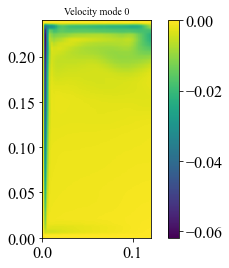

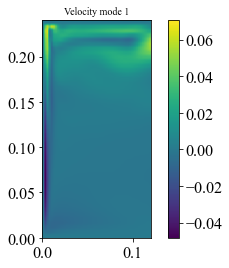

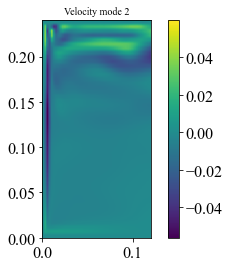

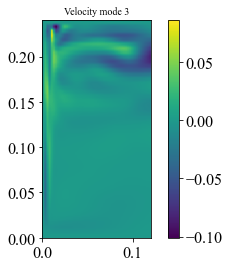

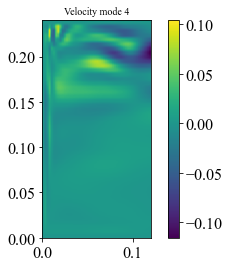

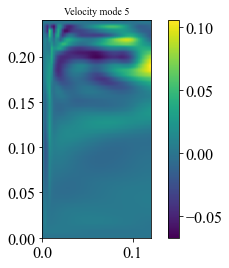

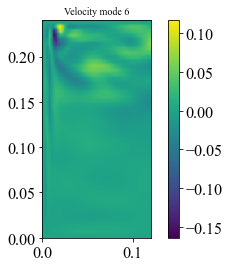

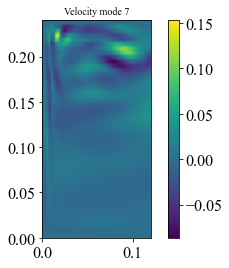

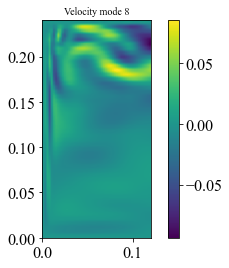

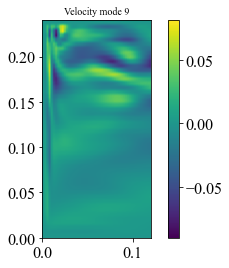

In [23]:
# Plot contours for basis functions
for i in range(Phi_U.shape[1]):
    
    plt.figure(i,facecolor=(1, 1, 1))
    v=Phi_U[:,i]
    zi = scipy.interpolate.griddata((x,y),v,(xi,yi),method="cubic")
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'
    plt.imshow(zi, vmin=v.min(), vmax=v.max(), origin="lower", extent=[x.min(), x.max(), y.min(), y.max()])
    plt.title("Velocity mode %i" %i, fontsize=10)
    plt.colorbar()
    plt.savefig('Velocity_mode_'+str(i)+'.png')
    del v,zi
    

In [24]:
print(os.getcwd())

C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


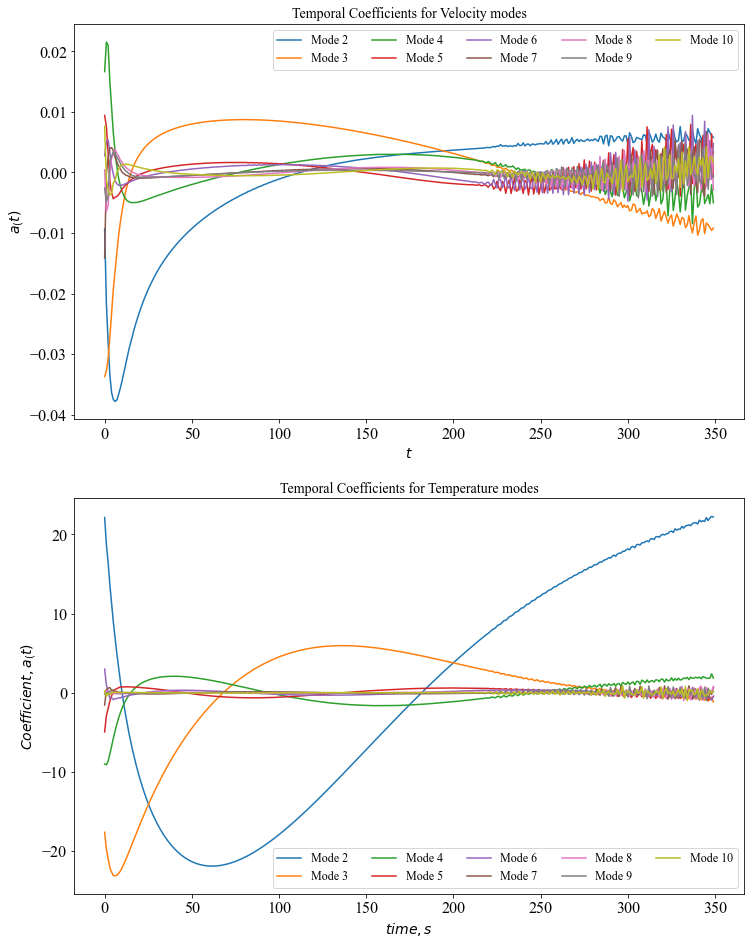

In [25]:

fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(12,16),facecolor=(1, 1, 1))
ax = ax.flat
ax[0].set_xlabel(r'$t$',fontsize=14)
ax[0].set_ylabel(r'$a_(t)$',fontsize=14)
ax[0].set_title(r'Temporal Coefficients for Velocity modes',fontsize=14)
ax[1].set_title(r'Temporal Coefficients for Temperature modes',fontsize=14)
ax[1].set_xlabel(r'$time,s$',fontsize=14)
ax[1].set_ylabel(r'$Coefficient, a_(t)$',fontsize=14)
for k in range(1, R[1],1): #steps by 1
    ax[0].plot(a_true_4_U.T[k,:], label=r'Mode %1.0f' %(k+1)) # Transpose is taken.
    ax[1].plot(a_true_4_T.T[k,:], label=r'Mode %1.0f' %(k+1))  # Transpose is taken.
    #ax[k].plot(t,aUROM[:,k,p], label=r'UROM',linestyle='-.', color = 'C1')
    #ax[k].plot(t,aGP16[:,k,p], label=r'GROM('+str(Q)+')',linestyle='--', color = 'C2')
    #ax[k].plot(t,aGP4[:,k,p], label=r'GROM('+str(R)+')',linestyle=':', color = 'C3')
    #ax[k].plot(t,aNIROM[:,k,p], label=r'NIROM',linestyle=':', color = 'C4')
    
    #ax[0].set_ylabel(r'$a_{'+str(k+1) +'}(t)$',fontsize=14)
    #ax[0].set_ylabel(r'$a$',fontsize=14)

ax[0].legend(loc='best' ,ncol=5,fontsize=12)  #
ax[1].legend(loc='best' ,ncol=5,fontsize=12)
#fig.subplots_adjust(bottom=0.15,hspace=0.7, wspace=0.35)
plt.savefig('Plots/2Dtempt_a_Re_mode2_included' +  \
            '_R=' + str(10) +  '.png',\
            dpi = 500, bbox_inches = 'tight')

In [ ]:
#whos

In [26]:

#load all files in order 1300
#Remove is null
#check Randomly if it looks oky

#Arrange the files in the dataset required. 1500

#Input POD and store modes and temporal coefficeints. (0900-1100 at night)

# Arrange temporal coefficients in the format required by LSTM. (tomorrow)

# Do long short term memory (LSTM) propagation. (tomorrow)

# Send results of reconstruction to Arijit.



In [27]:
a_true_4_U.shape  #num_snapshot x num_modes

(350, 10)

In [28]:
# Variables
# Spatial Modes
# Temporal modes

#split the obtained temporal coefficients data from POD  into training and testing data. 
#Scale the training data and save the scaling factor.
#Convert the training data into LSTM format 
# LSTM training to learn the pattern of temporal dynamics with num_features equivalent to num_of modes and its accompanying temporal coefficients 
# Testing : Scale the testing data and apply LSTM on it to obtain temporal coefficients.
#Convert back to original format and unscale it.
# Reconstruct the flow field using tested temporal coefficient and check with original flow field. 



#split training and testing dataset
def split_timeseries(df,nfrac=0.8):
    nlen=df.shape[0]
    nrow=int(nfrac*nlen)
    train_dataset = df.iloc[:nrow, :]
    test_dataset = df.iloc[nrow:,:]
    return train_dataset,test_dataset

train_dataset_ts,test_dataset_ts=split_timeseries(pd.DataFrame(a_true_4_U))

In [29]:
a_true_4_U.shape

(350, 10)

In [30]:
 Urecons=PODrec(a_true_4_U,Phi_U) #shape Grid_size x 10 x 10 x 350 (a.T)
 
# So to obtain reconstruction at a specific time t : obtain a at time(t) corresponding to all 10 modes 
# note the time index of lstm generated at test and obtain the reconstruction

In [31]:
for i in range(2,9):
    print(i)

2
3
4
5
6
7
8


In [32]:
#sc = MinMaxScaler(feature_range=(-1,1))
#training_set_scaled = sc.fit_transform(atrain) #sc.inverse_transform
#training_set = training_set_scaled

def create_training_data_lstm(training_set, m, n, lookback):
    ytrain = [training_set[i+1] for i in range(lookback-1,m-1)] #m-lookback
    ytrain = np.array(ytrain)
    xtrain = np.zeros((m-lookback,lookback,n))
    for i in range(m-lookback):
        a = training_set[i]
        for j in range(1,lookback):
            a = np.vstack((a,training_set[i+j]))
        xtrain[i] = a

    return xtrain, ytrain


lookback=3
m,n=a_true_4_U.shape
data_sc, labels_sc = create_training_data_lstm(a_true_4_U, m, n, lookback)

In [33]:
print("input lstm training database shape: ", data_sc.shape , " i.e. samples x timesteps x input_features" )
print("output lstm training database  shape: samples x output_feature", labels_sc.shape, " i.e. samples x timesteps x input_features" )

input lstm training database shape:  (347, 3, 10)  i.e. samples x timesteps x input_features
output lstm training database  shape: samples x output_feature (347, 10)  i.e. samples x timesteps x input_features


In [109]:
#Need to do scaling of variables. Since one variable is there, and results are coming good, so left it. For temperature variable below, scaling is done. See.

In [34]:
#Note : with shuffle False - LSTM results are not good as test dataset is outside the range. 
# Shuffle false is for splitting a time series dataset. Shuffle true ensures that test dataset is within training dataset.

from sklearn.model_selection import train_test_split
indices = np.arange(data_sc.shape[0])
xtrain, xvalid, ytrain, yvalid,indices_train, indices_test = train_test_split(data_sc, labels_sc, indices,test_size=0.3 , shuffle=True)


In [35]:
print(xtrain.shape,xvalid.shape,ytrain.shape,yvalid.shape)
print(data_sc.shape)

(242, 3, 10) (105, 3, 10) (242, 10) (105, 10)
(347, 3, 10)


In [36]:
print(a_true_4_U.shape, m, n, lookback)

(350, 10) 350 10 3


#### Below : check timeindex and its use in comparing original data "a_true_4_u" with LSTM predictions ytest/ytrain - as for training LSTM , the original database was converted. 

In [37]:
data_sc[indices_train[0]][:,0] #first 3 a_t belonging to mode number 0 in lstm training.

array([-0.05362253, -0.05347526, -0.05334802])

In [38]:
a_true_4_U[:6,0]

array([-0.13916447, -0.12907941, -0.12137284, -0.11235419, -0.10492426,
       -0.09813633])

In [39]:
#create timeindex
timeindex_train_label=indices_train+lookback #checklabel
print(timeindex_train_label)

[ 38 220 288  22 244 202 186 338 312  64  73 111   8  23 266 155  72  32
  20  90  79 320 192 107 321  63  24 265 109 130  52 199  61  78 339 184
  41 349 194 178 216 135 231 267  71 157   3  53 191 226 290  58 291 197
  86 261 256 233  66 132 298 307 300 280  89 201 163  49 218 165 277  87
 297 325 228   5 140 209 310 119 123 346 183 196 269  35 317  10  12 106
  94  42  31 313 296 282 172 327 276 156 345 255 112 311  75 139 318 258
 221 324 171 341 309 174 239 164 152 285 272 217 118 302 343 120  51 110
 314 281  85 158 102  98 193  70  69  99  25 169 127 195 273 104 162 283
 147 304 212  33 245  15  93  44 236 301  56 181 326 279  54  17 284   6
  26 131 168 204  48 238 240  45 235  82 188 334 223 271 115  14 153 237
  88 249 137 146 274 293 185 305   7 136  47 253 292 287 206 138 148  74
 121 319 347 219  77 344 251  97 328  96  21 286 295 316  34 143  92 161
 289 144 246  16  80 336 182 180 203  36  65 125  57 242  19  43 259  76
  11 224 159 126 323  18 128 268]


#print(a_true_4_U[timeindex_train_label,0]) #checking that timeindex (index + lookback) in original database is equal to predicted values in ytrain.
#print(ytrain[:,0])
if np.testing.assert_allclose(a_true_4_U[timeindex_train_label,0], ytrain[:,0]):
     print("Matched")
else:
     print("Not Matched")
print(np.testing.assert_allclose(a_true_4_U[timeindex_train_label,0], ytrain[:,0],rtol=1e-5, atol=0))

In [40]:
np.array_equal(a_true_4_U[timeindex_train_label,:], ytrain[:,:])

True

In [41]:
timeindex_test_label=indices_test+lookback #checklabel
np.array_equal(a_true_4_U[timeindex_test_label,:], yvalid[:,:]) #so what ever has been predicted by lstm for input of xtest has to be compared with this.

True

In [50]:
#Optuna based optimization
best_booster = None
gbm = None

#def callback(study, trial):
#    global best_booster
#    if study.best_trial == trial:
#        best_booster = gbm
            
def objective(trial):# For LSTM model
    global gbm
    # ...

            
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.models import load_model

        # For LSTM model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.models import load_model
    
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()
    
    Q=xtrain.shape[1] # -1 was used because featuer of Reynolds number was added.
    
    filenamelstm='LSTM Models1'
    import os
    if os.path.isdir("./"+filenamelstm):
        print('LSTM models folder already exists')
    else: 
        print('Creating LSTM models folder')
        os.makedirs("./"+filenamelstm)
    # Removing old models
    model_name = 'LSTM Models1/LSTM-Corrector.h5'
    if os.path.isfile(model_name):
        os.remove(model_name)

    ## Shuffling data    
    #perm = np.random.permutation(m)
    #xtrain = xtrain[perm,:,:]
    #ytrain = ytrain[perm,:]
    lstmtype=2
    
    lookback=3

    epochs=200
    
    batch_size=30
    
    #with strategy.scope():
    
    #val_loss,model3=NIROM_LSTM_training_with_optuna(trial,filenamelstm,model_name,lstmtype,lookback,Q)
    model3 = create_model(trial)
    #Criteria for early stoping, model saving and reducing learning rate on the fly.
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
    callbacks=[TFKerasPruningCallback(trial, "val_loss"),es,mc,reduce_lr]
    print(epochs,batch_size,'epochs')   
    # run the model
    history = model3.fit(xtrain, ytrain, epochs=epochs, batch_size=batch_size,validation_split=0.2,\
                         callbacks=[TFKerasPruningCallback(trial, "val_loss")]) #inculde ,es,mc,reduce_lr

    # evaluate the model
    scores = model3.evaluate(xtrain, ytrain, verbose=0)
    print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
        
    return val_loss[-1]


In [43]:
def show_result(study):

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [44]:
print(xtrain.shape[1:])

(3, 10)


In [45]:
def create_model(trial):
    # We optimize the numbers of layers, their units and weight decay parameter.

    n_layers = trial.suggest_int("n_layers", 1, 3)
    #weight_decay = trial.suggest_float("weight_decay",  2e-6, 1e-1, log=True)
    #lr = trial.suggest_float("lr", 0.05, 0.06, log=True)
      
    #momentum = trial.suggest_float("momentum", 0.8, 1.0)
    model = Sequential()

    for i in range(n_layers):
        
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.21, 0.42)

        num_hidden = trial.suggest_int("n_units_l{}".format(i), 20, 150, log=True)
        
        if i < max(range(n_layers)):
            rs = True
        else:
            rs = False # final hidden 

        Q=xtrain.shape[2]

        model.add(LSTM(num_hidden, input_shape=(xtrain.shape[1:]), return_sequences=rs))

        model.add(Dropout(rate=dropout)) 

        #model.add(BatchNormalization())
        
        #model.add(LSTM(num_hidden))

        #model.add(Dropout(rate=dropout)) 

        #model.add(BatchNormalization())
        
        #model.add(Dense(num_hidden, activation='relu'))

        #model.add(Dropout(rate=dropout)) 
        
#        model.add(tf.keras.layers.Flatten())
#        model.add(Dense(
#                num_hidden,
#                activation="relu",
#                kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
#            )
#        )
# Compile model for classification , kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
    model.add(Dense(Q, activation='linear')) #, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)
        #tf.keras.layers.Dense(2, kernel_regularizer=tf.keras.regularizers.l2(weight_decay)))

    # Compile model for classification
    #model.compile(
    #    optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=momentum, nesterov=True),
    #    loss="sparse_categorical_crossentropy",
    #    metrics=["accuracy"],
    #)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

    return model


In [46]:
#atrain is original field stacked
#errortrain is error field stacked
def NIROM_LSTM_trainingnooptuna(filenameLSTM,model_name,lstmtype,lookback,Q,optuna1='false'): 
    # (nc,ns,Q,Re,aTrain,errortrain,lookback,epochs,batch_size,lstmtype):
        
    # Parameters to vary
    activation =  "relu"
    n_neurons=60
    dropout = 0
            
    
    epochs=200
    
    batch_size=30
    
    
    if lstmtype==2: 
        model3 = Sequential()              
        model3.add(LSTM(n_neurons, input_shape=(lookback,Q), return_sequences=True, activation=activation)) # 
        model3.add(LSTM(n_neurons,  return_sequences=True, activation=activation,dropout=dropout))
        model3.add(LSTM(n_neurons,  activation=activation,dropout=dropout))
        model3.add(Dense(Q,activation='linear')) #gives Q output values 
    elif lstmtype==5: #Stateful LSTM (Avoid)
        model3 = Sequential()
        model3.add(LSTM(n_neurons, input_shape=(lookback,Q), return_sequences=True, activation=activation)) # 
        model3.add(LSTM(n_neurons,  return_sequences=True, activation=activation,dropout=dropout))
        model3.add(LSTM(n_neurons,  activation=activation,dropout=dropout))
        model3.add(Dense(Q,activation='linear'))        #https://stackoverflow.com/questions/64309194/invalidargumenterror-specified-a-list-with-shape-60-9-from-a-tensor-with-shap
    else: #SimpleLSTM
        model3 = Sequential()
        model3.add(LSTM(n_neurons, input_shape=(lookback,Q), return_sequences=False, activation='tanh')) # 
        model3.add(Dense(Q))

    # compile model
    model3.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
    #Criteria for early stoping, model saving and reducing learning rate on the fly.
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
    callbacks=[es,mc,reduce_lr]
    print(epochs,batch_size,'epochs')   
    # run the model
    history = model3.fit(xtrain, ytrain, epochs=epochs, batch_size=batch_size,validation_split=0.2) #callbacks=[es,mc,reduce_lr]

    # evaluate the model
    scores = model3.evaluate(xtrain, ytrain, verbose=0)
    print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    
    
    

    # Save the scales
  #  filename = 'LSTM Models1/NIROM_input_scaler.save'
  #  joblib.dump(scalerIn3,filename) 
  #  filename = 'LSTM Models1/NIROM_output_scaler.save'
  #  joblib.dump(scalerOut3,filename) 
  #  print ("VALIDATION LOSS", val_loss[-1])
    
    return loss,val_loss,model3


In [51]:
# For LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
#Optuna
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

# For LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

#from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay


study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=30)
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
show_result(study)


[I 2022-07-06 18:50:46,910] A new study created in memory with name: no-name-3c08b980-80ba-4f6c-bd73-07dd751e39e1


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 4s 128ms/step - loss: 6.2007e-04 - mse: 6.2007e-04 - val_loss: 3.2750e-04 - val_mse: 3.2750e-04
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 2.7996e-04 - mse: 2.7996e-04 - val_loss: 1.1523e-04 - val_mse: 1.1523e-04
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 1.3866e-04 - mse: 1.3866e-04 - val_loss: 5.5139e-05 - val_mse: 5.5139e-05
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 1.2248e-04 - mse: 1.2248e-04 - val_loss: 5.7550e-05 - val_mse: 5.7550e-05
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 1.1898e-04 - mse: 1.1898e-04 - val_loss: 5.3054e-05 - val_mse: 5.3054e-05
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 1.0409e-04 - mse: 1.0409e-04 - val_loss: 4.9287e-05 - val_mse: 4.9287e-05
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 8.9

[I 2022-07-06 18:51:10,178] Trial 0 finished with value: 1.5428425967911608e-06 and parameters: {'n_layers': 1, 'dropout_l0': 0.313400185921236, 'n_units_l0': 36}. Best is trial 0 with value: 1.5428425967911608e-06.


mse: 0.00%
LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 11s 341ms/step - loss: 3.7905e-04 - mse: 3.7905e-04 - val_loss: 6.8466e-05 - val_mse: 6.8466e-05
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0036e-04 - mse: 1.0036e-04 - val_loss: 1.0005e-04 - val_mse: 1.0005e-04
Epoch 3/200
7/7 [==============================] - 0s 20ms/step - loss: 1.0035e-04 - mse: 1.0035e-04 - val_loss: 4.7347e-05 - val_mse: 4.7347e-05
Epoch 4/200
7/7 [==============================] - 0s 20ms/step - loss: 7.4426e-05 - mse: 7.4426e-05 - val_loss: 5.9609e-05 - val_mse: 5.9609e-05
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 7.2932e-05 - mse: 7.2932e-05 - val_loss: 4.9584e-05 - val_mse: 4.9584e-05
Epoch 6/200
7/7 [==============================] - 0s 20ms/step - loss: 6.4746e-05 - mse: 6.4746e-05 - val_loss: 4.8140e-05 - val_mse: 4.8140e-05
Epoch 7/200
7/7 [==============================] - 0s 20ms/step

[I 2022-07-06 18:51:58,567] Trial 1 finished with value: 2.4414048311882652e-06 and parameters: {'n_layers': 3, 'dropout_l0': 0.30308544010901217, 'n_units_l0': 96, 'dropout_l1': 0.22197671524309723, 'n_units_l1': 75, 'dropout_l2': 0.2232875207923282, 'n_units_l2': 59}. Best is trial 0 with value: 1.5428425967911608e-06.


mse: 0.00%
LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 32s 1s/step - loss: 4.2344e-04 - mse: 4.2344e-04 - val_loss: 1.3243e-04 - val_mse: 1.3243e-04
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2538e-04 - mse: 1.2538e-04 - val_loss: 5.8395e-05 - val_mse: 5.8395e-05
Epoch 3/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1451e-04 - mse: 1.1451e-04 - val_loss: 6.7407e-05 - val_mse: 6.7407e-05
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0649e-04 - mse: 1.0649e-04 - val_loss: 5.2027e-05 - val_mse: 5.2027e-05
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 8.8163e-05 - mse: 8.8163e-05 - val_loss: 5.0722e-05 - val_mse: 5.0722e-05
Epoch 6/200
7/7 [==============================] - 0s 29ms/step - loss: 7.8575e-05 - mse: 7.8575e-05 - val_loss: 5.1398e-05 - val_mse: 5.1398e-05
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - 

[I 2022-07-06 18:52:38,624] Trial 2 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 6s 119ms/step - loss: 5.9967e-04 - mse: 5.9967e-04 - val_loss: 3.1713e-04 - val_mse: 3.1713e-04
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 2.8090e-04 - mse: 2.8090e-04 - val_loss: 1.1590e-04 - val_mse: 1.1590e-04
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 1.5136e-04 - mse: 1.5136e-04 - val_loss: 5.4272e-05 - val_mse: 5.4272e-05
Epoch 4/200
7/7 [==============================] - 0s 10ms/step - loss: 1.4046e-04 - mse: 1.4046e-04 - val_loss: 5.2860e-05 - val_mse: 5.2860e-05
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 1.2867e-04 - mse: 1.2867e-04 - val_loss: 4.8628e-05 - val_mse: 4.8628e-05
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 1.1200e-04 - mse: 1.1200e-04 - val_loss: 4.7586e-05 - val_mse: 4.7586e-05
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 1.0

[I 2022-07-06 18:53:02,492] Trial 3 finished with value: 1.926260438267491e-06 and parameters: {'n_layers': 1, 'dropout_l0': 0.3427469941602108, 'n_units_l0': 24}. Best is trial 0 with value: 1.5428425967911608e-06.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 4s 122ms/step - loss: 3.4946e-04 - mse: 3.4946e-04 - val_loss: 7.7187e-05 - val_mse: 7.7187e-05
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 8.9041e-05 - mse: 8.9041e-05 - val_loss: 6.4089e-05 - val_mse: 6.4089e-05


[I 2022-07-06 18:53:07,427] Trial 4 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 7s 222ms/step - loss: 5.0430e-04 - mse: 5.0430e-04 - val_loss: 2.5498e-04 - val_mse: 2.5498e-04
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 2.1429e-04 - mse: 2.1429e-04 - val_loss: 6.9993e-05 - val_mse: 6.9993e-05
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 1.2543e-04 - mse: 1.2543e-04 - val_loss: 4.3420e-05 - val_mse: 4.3420e-05
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 1.2703e-04 - mse: 1.2703e-04 - val_loss: 4.5624e-05 - val_mse: 4.5624e-05
Epoch 5/200
7/7 [==============================] - 0s 14ms/step - loss: 1.0599e-04 - mse: 1.0599e-04 - val_loss: 4.5602e-05 - val_mse: 4.5602e-05
Epoch 6/200
7/7 [==============================] - 0s 13ms/step - loss: 9.1616e-05 - mse: 9.1616e-05 - val_loss: 4.7119e-05 - val_mse: 4.7119e-05
Epoch 7/200
7/7 [==============================] - 0s 18ms/step - loss: 9.4

[I 2022-07-06 18:53:39,048] Trial 5 finished with value: 2.3499474082200322e-06 and parameters: {'n_layers': 2, 'dropout_l0': 0.3724661175199694, 'n_units_l0': 24, 'dropout_l1': 0.31865925865869515, 'n_units_l1': 25}. Best is trial 0 with value: 1.5428425967911608e-06.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 8s 232ms/step - loss: 4.6305e-04 - mse: 4.6305e-04 - val_loss: 1.7008e-04 - val_mse: 1.7008e-04
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 1.6605e-04 - mse: 1.6605e-04 - val_loss: 4.5306e-05 - val_mse: 4.5306e-05
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 1.4121e-04 - mse: 1.4121e-04 - val_loss: 5.2892e-05 - val_mse: 5.2892e-05
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 1.1546e-04 - mse: 1.1546e-04 - val_loss: 4.6517e-05 - val_mse: 4.6517e-05
Epoch 5/200
7/7 [==============================] - 0s 13ms/step - loss: 9.7322e-05 - mse: 9.7322e-05 - val_loss: 5.6957e-05 - val_mse: 5.6957e-05
Epoch 6/200
7/7 [==============================] - 0s 14ms/step - loss: 9.5357e-05 - mse: 9.5357e-05 - val_loss: 4.9699e-05 - val_mse: 4.9699e-05
Epoch 7/200
7/7 [==============================] - 0s 14ms/step - loss: 8.4

[I 2022-07-06 18:54:13,318] Trial 6 finished with value: 1.700816710581421e-06 and parameters: {'n_layers': 2, 'dropout_l0': 0.2578085630703172, 'n_units_l0': 96, 'dropout_l1': 0.31929570139471875, 'n_units_l1': 30}. Best is trial 0 with value: 1.5428425967911608e-06.


mse: 0.00%
LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 4s 119ms/step - loss: 3.5973e-04 - mse: 3.5973e-04 - val_loss: 6.7887e-05 - val_mse: 6.7887e-05
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 8.6761e-05 - mse: 8.6761e-05 - val_loss: 8.5857e-05 - val_mse: 8.5857e-05


[I 2022-07-06 18:54:18,299] Trial 7 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 7s 214ms/step - loss: 4.7781e-04 - mse: 4.7781e-04 - val_loss: 1.8116e-04 - val_mse: 1.8116e-04
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 1.7853e-04 - mse: 1.7853e-04 - val_loss: 4.5160e-05 - val_mse: 4.5160e-05
Epoch 3/200
7/7 [==============================] - 0s 14ms/step - loss: 1.7765e-04 - mse: 1.7765e-04 - val_loss: 4.8184e-05 - val_mse: 4.8184e-05
Epoch 4/200
7/7 [==============================] - 0s 15ms/step - loss: 1.4093e-04 - mse: 1.4093e-04 - val_loss: 4.8433e-05 - val_mse: 4.8433e-05
Epoch 5/200
7/7 [==============================] - 0s 14ms/step - loss: 1.2123e-04 - mse: 1.2123e-04 - val_loss: 5.8656e-05 - val_mse: 5.8656e-05
Epoch 6/200
7/7 [==============================] - 0s 15ms/step - loss: 1.1591e-04 - mse: 1.1591e-04 - val_loss: 5.7766e-05 - val_mse: 5.7766e-05
Epoch 7/200
7/7 [==============================] - 0s 15ms/step - loss: 9.9

[I 2022-07-06 18:54:35,010] Trial 8 pruned. Trial was pruned at epoch 81.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 8s 210ms/step - loss: 4.6524e-04 - mse: 4.6524e-04 - val_loss: 1.8963e-04 - val_mse: 1.8963e-04
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 1.6699e-04 - mse: 1.6699e-04 - val_loss: 4.7051e-05 - val_mse: 4.7051e-05
Epoch 3/200
7/7 [==============================] - 0s 25ms/step - loss: 1.2510e-04 - mse: 1.2510e-04 - val_loss: 5.6556e-05 - val_mse: 5.6556e-05
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 1.2455e-04 - mse: 1.2455e-04 - val_loss: 4.6178e-05 - val_mse: 4.6178e-05
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 1.0205e-04 - mse: 1.0205e-04 - val_loss: 5.3823e-05 - val_mse: 5.3823e-05
Epoch 6/200
7/7 [==============================] - 0s 15ms/step - loss: 9.0303e-05 - mse: 9.0303e-05 - val_loss: 5.4095e-05 - val_mse: 5.4095e-05
Epoch 7/200
7/7 [==============================] - 0s 14ms/step - loss: 8.1

[I 2022-07-06 18:54:45,227] Trial 9 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 4s 118ms/step - loss: 5.4117e-04 - mse: 5.4117e-04 - val_loss: 2.2933e-04 - val_mse: 2.2933e-04
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 1.8713e-04 - mse: 1.8713e-04 - val_loss: 5.8509e-05 - val_mse: 5.8509e-05
Epoch 3/200
7/7 [==============================] - 0s 11ms/step - loss: 1.0751e-04 - mse: 1.0751e-04 - val_loss: 4.9033e-05 - val_mse: 4.9033e-05
Epoch 4/200
7/7 [==============================] - 0s 11ms/step - loss: 1.0927e-04 - mse: 1.0927e-04 - val_loss: 4.8926e-05 - val_mse: 4.8926e-05
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 9.0790e-05 - mse: 9.0790e-05 - val_loss: 3.8452e-05 - val_mse: 3.8452e-05
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 7.4164e-05 - mse: 7.4164e-05 - val_loss: 3.9300e-05 - val_mse: 3.9300e-05
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 7.4

[I 2022-07-06 18:55:07,320] Trial 10 finished with value: 1.644658937038912e-06 and parameters: {'n_layers': 1, 'dropout_l0': 0.2821524817982996, 'n_units_l0': 34}. Best is trial 0 with value: 1.5428425967911608e-06.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 10s 305ms/step - loss: 4.7914e-04 - mse: 4.7914e-04 - val_loss: 2.0294e-04 - val_mse: 2.0294e-04
Epoch 2/200
7/7 [==============================] - 0s 18ms/step - loss: 1.7342e-04 - mse: 1.7342e-04 - val_loss: 5.0425e-05 - val_mse: 5.0425e-05
Epoch 3/200
7/7 [==============================] - 0s 19ms/step - loss: 1.4551e-04 - mse: 1.4551e-04 - val_loss: 5.8398e-05 - val_mse: 5.8398e-05
Epoch 4/200
7/7 [==============================] - 0s 18ms/step - loss: 1.3386e-04 - mse: 1.3386e-04 - val_loss: 5.0094e-05 - val_mse: 5.0094e-05
Epoch 5/200
7/7 [==============================] - 0s 19ms/step - loss: 1.1624e-04 - mse: 1.1624e-04 - val_loss: 5.7466e-05 - val_mse: 5.7466e-05
Epoch 6/200
7/7 [==============================] - 0s 18ms/step - loss: 1.0447e-04 - mse: 1.0447e-04 - val_loss: 5.9951e-05 - val_mse: 5.9951e-05
Epoch 7/200
7/7 [==============================] - 0s 21ms/step - loss: 1.

[I 2022-07-06 18:55:20,263] Trial 11 pruned. Trial was pruned at epoch 9.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 7s 250ms/step - loss: 4.2803e-04 - mse: 4.2803e-04 - val_loss: 1.3750e-04 - val_mse: 1.3750e-04
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 1.3111e-04 - mse: 1.3111e-04 - val_loss: 4.7903e-05 - val_mse: 4.7903e-05


[I 2022-07-06 18:55:28,301] Trial 12 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 17s 467ms/step - loss: 3.9292e-04 - mse: 3.9292e-04 - val_loss: 7.6327e-05 - val_mse: 7.6327e-05
Epoch 2/200
7/7 [==============================] - 0s 17ms/step - loss: 1.2543e-04 - mse: 1.2543e-04 - val_loss: 8.4681e-05 - val_mse: 8.4681e-05
Epoch 3/200
7/7 [==============================] - 0s 17ms/step - loss: 1.2912e-04 - mse: 1.2912e-04 - val_loss: 4.8621e-05 - val_mse: 4.8621e-05
Epoch 4/200
7/7 [==============================] - 0s 17ms/step - loss: 9.7780e-05 - mse: 9.7780e-05 - val_loss: 6.5167e-05 - val_mse: 6.5167e-05
Epoch 5/200
7/7 [==============================] - 0s 18ms/step - loss: 9.1729e-05 - mse: 9.1729e-05 - val_loss: 5.1933e-05 - val_mse: 5.1933e-05
Epoch 6/200
7/7 [==============================] - 0s 17ms/step - loss: 8.8297e-05 - mse: 8.8297e-05 - val_loss: 4.7550e-05 - val_mse: 4.7550e-05
Epoch 7/200
7/7 [==============================] - 0s 18ms/step - loss: 8.

[I 2022-07-06 18:55:52,283] Trial 13 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 6s 268ms/step - loss: 4.3862e-04 - mse: 4.3862e-04 - val_loss: 1.1579e-04 - val_mse: 1.1579e-04
Epoch 2/200
7/7 [==============================] - 0s 11ms/step - loss: 8.6470e-05 - mse: 8.6470e-05 - val_loss: 5.8098e-05 - val_mse: 5.8098e-05


[I 2022-07-06 18:55:59,687] Trial 14 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 21s 369ms/step - loss: 4.2264e-04 - mse: 4.2264e-04 - val_loss: 1.3286e-04 - val_mse: 1.3286e-04
Epoch 2/200
7/7 [==============================] - 0s 17ms/step - loss: 1.6847e-04 - mse: 1.6847e-04 - val_loss: 4.9450e-05 - val_mse: 4.9450e-05
Epoch 3/200
7/7 [==============================] - 0s 18ms/step - loss: 1.6410e-04 - mse: 1.6410e-04 - val_loss: 5.3942e-05 - val_mse: 5.3942e-05
Epoch 4/200
7/7 [==============================] - 0s 17ms/step - loss: 1.3420e-04 - mse: 1.3420e-04 - val_loss: 5.3616e-05 - val_mse: 5.3616e-05


[I 2022-07-06 18:56:22,079] Trial 15 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 19s 515ms/step - loss: 4.6405e-04 - mse: 4.6405e-04 - val_loss: 1.8774e-04 - val_mse: 1.8774e-04
Epoch 2/200
7/7 [==============================] - 0s 19ms/step - loss: 1.9346e-04 - mse: 1.9346e-04 - val_loss: 4.9278e-05 - val_mse: 4.9278e-05
Epoch 3/200
7/7 [==============================] - 0s 18ms/step - loss: 1.7461e-04 - mse: 1.7461e-04 - val_loss: 5.4511e-05 - val_mse: 5.4511e-05
Epoch 4/200
7/7 [==============================] - 0s 18ms/step - loss: 1.5123e-04 - mse: 1.5123e-04 - val_loss: 5.4875e-05 - val_mse: 5.4875e-05


[I 2022-07-06 18:56:43,197] Trial 16 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 10s 296ms/step - loss: 4.1416e-04 - mse: 4.1416e-04 - val_loss: 9.9962e-05 - val_mse: 9.9962e-05
Epoch 2/200
7/7 [==============================] - 0s 16ms/step - loss: 1.5023e-04 - mse: 1.5023e-04 - val_loss: 6.0806e-05 - val_mse: 6.0806e-05


[I 2022-07-06 18:56:55,489] Trial 17 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 8s 292ms/step - loss: 4.0980e-04 - mse: 4.0980e-04 - val_loss: 8.8619e-05 - val_mse: 8.8619e-05
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 9.0667e-05 - mse: 9.0667e-05 - val_loss: 8.6777e-05 - val_mse: 8.6777e-05


[I 2022-07-06 18:57:04,374] Trial 18 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 7s 227ms/step - loss: 3.3507e-04 - mse: 3.3507e-04 - val_loss: 4.6586e-05 - val_mse: 4.6586e-05
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 9.9813e-05 - mse: 9.9813e-05 - val_loss: 9.3282e-05 - val_mse: 9.3282e-05
Epoch 3/200
7/7 [==============================] - 0s 15ms/step - loss: 9.1754e-05 - mse: 9.1754e-05 - val_loss: 4.2886e-05 - val_mse: 4.2886e-05
Epoch 4/200
7/7 [==============================] - 0s 16ms/step - loss: 7.4477e-05 - mse: 7.4477e-05 - val_loss: 5.6451e-05 - val_mse: 5.6451e-05


[I 2022-07-06 18:57:12,814] Trial 19 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 13s 267ms/step - loss: 3.9882e-04 - mse: 3.9882e-04 - val_loss: 8.6561e-05 - val_mse: 8.6561e-05
Epoch 2/200
7/7 [==============================] - 0s 14ms/step - loss: 1.0961e-04 - mse: 1.0961e-04 - val_loss: 7.5135e-05 - val_mse: 7.5135e-05
Epoch 3/200
7/7 [==============================] - 0s 15ms/step - loss: 1.1165e-04 - mse: 1.1165e-04 - val_loss: 5.0456e-05 - val_mse: 5.0456e-05
Epoch 4/200
7/7 [==============================] - 0s 15ms/step - loss: 7.9983e-05 - mse: 7.9983e-05 - val_loss: 5.0706e-05 - val_mse: 5.0706e-05
Epoch 5/200
7/7 [==============================] - 0s 15ms/step - loss: 7.6027e-05 - mse: 7.6027e-05 - val_loss: 4.7964e-05 - val_mse: 4.7964e-05
Epoch 6/200
7/7 [==============================] - 0s 17ms/step - loss: 7.0237e-05 - mse: 7.0237e-05 - val_loss: 3.8198e-05 - val_mse: 3.8198e-05
Epoch 7/200
7/7 [==============================] - 0s 17ms/step - loss: 6.

[I 2022-07-06 18:57:49,056] Trial 20 finished with value: 1.6338628938683541e-06 and parameters: {'n_layers': 2, 'dropout_l0': 0.26789486761361514, 'n_units_l0': 111, 'dropout_l1': 0.235917090773084, 'n_units_l1': 38}. Best is trial 0 with value: 1.5428425967911608e-06.


mse: 0.00%
LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 7s 220ms/step - loss: 4.2429e-04 - mse: 4.2429e-04 - val_loss: 1.2896e-04 - val_mse: 1.2896e-04
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.6238e-04 - mse: 1.6238e-04 - val_loss: 4.5633e-05 - val_mse: 4.5633e-05
Epoch 3/200
7/7 [==============================] - 0s 17ms/step - loss: 1.4702e-04 - mse: 1.4702e-04 - val_loss: 5.0379e-05 - val_mse: 5.0379e-05
Epoch 4/200
7/7 [==============================] - 0s 19ms/step - loss: 1.1361e-04 - mse: 1.1361e-04 - val_loss: 4.5899e-05 - val_mse: 4.5899e-05
Epoch 5/200
7/7 [==============================] - 0s 19ms/step - loss: 9.3178e-05 - mse: 9.3178e-05 - val_loss: 4.7965e-05 - val_mse: 4.7965e-05
Epoch 6/200
7/7 [==============================] - 0s 18ms/step - loss: 8.6020e-05 - mse: 8.6020e-05 - val_loss: 4.5435e-05 - val_mse: 4.5435e-05
Epoch 7/200
7/7 [==============================] - 0s 19ms/step 

[I 2022-07-06 18:58:08,712] Trial 21 pruned. Trial was pruned at epoch 81.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 16s 860ms/step - loss: 3.6745e-04 - mse: 3.6745e-04 - val_loss: 6.3610e-05 - val_mse: 6.3610e-05
Epoch 2/200
7/7 [==============================] - 1s 97ms/step - loss: 8.6034e-05 - mse: 8.6034e-05 - val_loss: 1.1656e-04 - val_mse: 1.1656e-04


[I 2022-07-06 18:58:27,372] Trial 22 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 12s 349ms/step - loss: 5.9668e-04 - mse: 5.9668e-04 - val_loss: 3.0615e-04 - val_mse: 3.0615e-04
Epoch 2/200
7/7 [==============================] - 0s 13ms/step - loss: 2.8469e-04 - mse: 2.8469e-04 - val_loss: 1.2643e-04 - val_mse: 1.2643e-04
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 1.8807e-04 - mse: 1.8807e-04 - val_loss: 5.8095e-05 - val_mse: 5.8095e-05
Epoch 4/200
7/7 [==============================] - 0s 13ms/step - loss: 1.4924e-04 - mse: 1.4924e-04 - val_loss: 4.4145e-05 - val_mse: 4.4145e-05
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 1.3955e-04 - mse: 1.3955e-04 - val_loss: 4.2796e-05 - val_mse: 4.2796e-05
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 1.2086e-04 - mse: 1.2086e-04 - val_loss: 4.2478e-05 - val_mse: 4.2478e-05
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 1.

[I 2022-07-06 18:58:44,635] Trial 23 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 17s 1s/step - loss: 3.4275e-04 - mse: 3.4275e-04 - val_loss: 4.8399e-05 - val_mse: 4.8399e-05
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0571e-04 - mse: 1.0571e-04 - val_loss: 1.0155e-04 - val_mse: 1.0155e-04
Epoch 3/200
7/7 [==============================] - 0s 21ms/step - loss: 8.3148e-05 - mse: 8.3148e-05 - val_loss: 5.1298e-05 - val_mse: 5.1298e-05
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 7.3439e-05 - mse: 7.3439e-05 - val_loss: 5.8916e-05 - val_mse: 5.8916e-05
Epoch 5/200
7/7 [==============================] - 0s 20ms/step - loss: 6.4213e-05 - mse: 6.4213e-05 - val_loss: 4.8043e-05 - val_mse: 4.8043e-05
Epoch 6/200
7/7 [==============================] - 0s 20ms/step - loss: 6.1724e-05 - mse: 6.1724e-05 - val_loss: 4.9247e-05 - val_mse: 4.9247e-05
Epoch 7/200
7/7 [==============================] - 0s 19ms/step - loss: 5.779

[I 2022-07-06 18:59:32,035] Trial 24 finished with value: 2.4116295662679477e-06 and parameters: {'n_layers': 3, 'dropout_l0': 0.24274077816920298, 'n_units_l0': 53, 'dropout_l1': 0.23405925491713625, 'n_units_l1': 68, 'dropout_l2': 0.23609168339469158, 'n_units_l2': 136}. Best is trial 0 with value: 1.5428425967911608e-06.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 12s 383ms/step - loss: 4.3765e-04 - mse: 4.3765e-04 - val_loss: 1.3387e-04 - val_mse: 1.3387e-04
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2831e-04 - mse: 1.2831e-04 - val_loss: 6.2132e-05 - val_mse: 6.2132e-05
Epoch 3/200
7/7 [==============================] - 0s 32ms/step - loss: 1.4305e-04 - mse: 1.4305e-04 - val_loss: 5.3811e-05 - val_mse: 5.3811e-05
Epoch 4/200
7/7 [==============================] - 0s 26ms/step - loss: 9.9601e-05 - mse: 9.9601e-05 - val_loss: 5.5523e-05 - val_mse: 5.5523e-05
Epoch 5/200
7/7 [==============================] - 0s 20ms/step - loss: 9.6484e-05 - mse: 9.6484e-05 - val_loss: 5.8350e-05 - val_mse: 5.8350e-05
Epoch 6/200
7/7 [==============================] - 0s 17ms/step - loss: 8.4570e-05 - mse: 8.4570e-05 - val_loss: 4.9603e-05 - val_mse: 4.9603e-05
Epoch 7/200
7/7 [==============================] - 0s 17ms/step - loss: 7.

[I 2022-07-06 18:59:50,908] Trial 25 pruned. Trial was pruned at epoch 27.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 11s 323ms/step - loss: 4.0962e-04 - mse: 4.0962e-04 - val_loss: 1.0943e-04 - val_mse: 1.0943e-04
Epoch 2/200
7/7 [==============================] - 0s 20ms/step - loss: 1.2048e-04 - mse: 1.2048e-04 - val_loss: 7.2264e-05 - val_mse: 7.2264e-05


[I 2022-07-06 19:00:03,984] Trial 26 pruned. Trial was pruned at epoch 1.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 4s 141ms/step - loss: 5.1088e-04 - mse: 5.1088e-04 - val_loss: 2.0232e-04 - val_mse: 2.0232e-04
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 1.4592e-04 - mse: 1.4592e-04 - val_loss: 5.0927e-05 - val_mse: 5.0927e-05
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 9.3963e-05 - mse: 9.3963e-05 - val_loss: 7.4924e-05 - val_mse: 7.4924e-05
Epoch 4/200
7/7 [==============================] - 0s 14ms/step - loss: 1.0955e-04 - mse: 1.0955e-04 - val_loss: 5.4737e-05 - val_mse: 5.4736e-05
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 7.6046e-05 - mse: 7.6046e-05 - val_loss: 4.5166e-05 - val_mse: 4.5166e-05
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 6.9468e-05 - mse: 6.9468e-05 - val_loss: 4.8650e-05 - val_mse: 4.8650e-05
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 6.5

[I 2022-07-06 19:00:27,250] Trial 27 finished with value: 1.332112788077211e-06 and parameters: {'n_layers': 1, 'dropout_l0': 0.22947110044505464, 'n_units_l0': 66}. Best is trial 27 with value: 1.332112788077211e-06.


mse: 0.00%
LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 13s 287ms/step - loss: 4.4426e-04 - mse: 4.4426e-04 - val_loss: 1.3712e-04 - val_mse: 1.3712e-04
Epoch 2/200
7/7 [==============================] - 0s 18ms/step - loss: 1.6103e-04 - mse: 1.6103e-04 - val_loss: 4.8891e-05 - val_mse: 4.8891e-05
Epoch 3/200
7/7 [==============================] - 0s 16ms/step - loss: 1.5151e-04 - mse: 1.5151e-04 - val_loss: 5.1258e-05 - val_mse: 5.1258e-05
Epoch 4/200
7/7 [==============================] - 0s 16ms/step - loss: 1.2105e-04 - mse: 1.2105e-04 - val_loss: 5.3727e-05 - val_mse: 5.3727e-05


[I 2022-07-06 19:00:41,672] Trial 28 pruned. Trial was pruned at epoch 3.


LSTM models folder already exists
200 30 epochs
Epoch 1/200
7/7 [==============================] - 6s 168ms/step - loss: 4.9823e-04 - mse: 4.9823e-04 - val_loss: 1.8920e-04 - val_mse: 1.8920e-04
Epoch 2/200
7/7 [==============================] - 0s 12ms/step - loss: 1.4138e-04 - mse: 1.4138e-04 - val_loss: 4.7065e-05 - val_mse: 4.7065e-05
Epoch 3/200
7/7 [==============================] - 0s 12ms/step - loss: 8.0116e-05 - mse: 8.0116e-05 - val_loss: 5.8356e-05 - val_mse: 5.8356e-05
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 9.2255e-05 - mse: 9.2255e-05 - val_loss: 4.8284e-05 - val_mse: 4.8284e-05
Epoch 5/200
7/7 [==============================] - 0s 12ms/step - loss: 7.3789e-05 - mse: 7.3789e-05 - val_loss: 3.4644e-05 - val_mse: 3.4644e-05
Epoch 6/200
7/7 [==============================] - 0s 12ms/step - loss: 6.3299e-05 - mse: 6.3299e-05 - val_loss: 3.7329e-05 - val_mse: 3.7329e-05
Epoch 7/200
7/7 [==============================] - 0s 12ms/step - loss: 5.8

[I 2022-07-06 19:01:06,008] Trial 29 finished with value: 1.458120891584258e-06 and parameters: {'n_layers': 1, 'dropout_l0': 0.2191975027251067, 'n_units_l0': 40}. Best is trial 27 with value: 1.332112788077211e-06.


Study statistics: 
  Number of finished trials:  30
  Number of pruned trials:  20
  Number of complete trials:  10
Best trial:
  Value:  1.332112788077211e-06
  Params: 
    n_layers: 1
    dropout_l0: 0.22947110044505464
    n_units_l0: 66


In [53]:
study.best_params


{'n_layers': 1, 'dropout_l0': 0.22947110044505464, 'n_units_l0': 66}

whos

In [54]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_dropout_l0,params_dropout_l1,params_dropout_l2,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,system_attrs_completed_rung_4,state
0,0,0.000002,2022-07-06 18:50:46.911480,2022-07-06 18:51:10.176888,0 days 00:00:23.265408,0.313400,NaN,NaN,1,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,0.000002,2022-07-06 18:51:10.179887,2022-07-06 18:51:58.564385,0 days 00:00:48.384498,0.303085,0.221977,0.223288,3,96,75.0,59.0,0.000100,0.000060,0.000046,0.000010,0.000003,COMPLETE
2,2,0.000046,2022-07-06 18:51:58.569385,2022-07-06 18:52:38.624327,0 days 00:00:40.054942,0.370733,0.303688,0.224387,3,35,89.0,29.0,0.000058,0.000052,0.000046,NaN,NaN,PRUNED
3,3,0.000002,2022-07-06 18:52:38.626324,2022-07-06 18:53:02.491272,0 days 00:00:23.864948,0.342747,NaN,NaN,1,24,NaN,NaN,0.000053,0.000043,0.000019,0.000002,NaN,COMPLETE
4,4,0.000064,2022-07-06 18:53:02.494271,2022-07-06 18:53:07.426394,0 days 00:00:04.932123,0.291129,NaN,NaN,1,75,NaN,NaN,0.000064,NaN,NaN,NaN,NaN,PRUNED
5,5,0.000002,2022-07-06 18:53:07.430395,2022-07-06 18:53:39.046742,0 days 00:00:31.616347,0.372466,0.318659,NaN,2,24,25.0,NaN,0.000013,0.000004,NaN,NaN,NaN,COMPLETE
6,6,0.000002,2022-07-06 18:53:39.050739,2022-07-06 18:54:13.317958,0 days 00:00:34.267219,0.257809,0.319296,NaN,2,96,30.0,NaN,0.000045,0.000047,0.000040,0.000009,0.000002,COMPLETE
7,7,0.000086,2022-07-06 18:54:13.320958,2022-07-06 18:54:18.299703,0 days 00:00:04.978745,0.291285,NaN,NaN,1,113,NaN,NaN,0.000086,NaN,NaN,NaN,NaN,PRUNED
8,8,0.000003,2022-07-06 18:54:18.300703,2022-07-06 18:54:35.010363,0 days 00:00:16.709660,0.346045,0.416702,NaN,2,88,34.0,NaN,0.000048,0.000039,0.000010,0.000003,NaN,PRUNED
9,9,0.000042,2022-07-06 18:54:35.011365,2022-07-06 18:54:45.227797,0 days 00:00:10.216432,0.210524,0.382104,NaN,2,21,48.0,NaN,0.000047,0.000046,0.000042,NaN,NaN,PRUNED


In [ ]:
xtrain.shape[2]

In [ ]:
plot_optimization_history(study)

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_intermediate_values(study)
fig.show()

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
#from keras.models import load_model



In [57]:
dict_para=study.best_params

In [ ]:
#**study.best_params

In [55]:
def create_model1(dict_para):
    # We optimize the numbers of layers, their units and weight decay parameter.

    n_layers = study.best_params['n_layers']
    
    #weight_decay = trial.suggest_float("weight_decay",  2e-6, 1e-1, log=True)
    #lr = trial.suggest_float("lr", 0.05, 0.06, log=True)
      
    #momentum = trial.suggest_float("momentum", 0.8, 1.0)
    model = Sequential()

    for i in range(n_layers):
        
        dropout = study.best_params['dropout_l0'] #trial.suggest_float("dropout_l{}".format(i), 0.21, 0.42)

        num_hidden = study.best_params['n_units_l0'] #trial.suggest_int("n_units_l{}".format(i), 20, 150, log=True)
        
        if i < max(range(n_layers)):
            rs = True
        else:
            rs = False # final hidden 

        Q=xtrain.shape[2]

        model.add(LSTM(num_hidden, input_shape=(xtrain.shape[1:]), return_sequences=rs))

        model.add(Dropout(rate=dropout)) 

    model.add(Dense(Q, activation='linear')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    mc = keras.callbacks.ModelCheckpoint(filepath=os.getcwd(),filename='{epoch}-{val_loss:.5f}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)
    callbacks=[es,mc,reduce_lr]
    epochs=300
    batch_size=32   
    # run the model
    history = model.fit(xtrain, ytrain, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[es,mc,reduce_lr]) #callbacks=[es,mc,reduce_lr]

    # evaluate the model
    scores = model.evaluate(xtrain, ytrain, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    return model,loss,val_loss


In [58]:
model,loss,val_loss=create_model1(dict_para)

Epoch 1/300
7/7 [==============================] - 4s 124ms/step - loss: 2.8972e-04 - mse: 2.8972e-04 - val_loss: 5.3038e-05 - val_mse: 5.3038e-05

Epoch 00001: val_loss improved from inf to 0.00005, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 2/300
7/7 [==============================] - 0s 14ms/step - loss: 7.4140e-05 - mse: 7.4140e-05 - val_loss: 7.1503e-05 - val_mse: 7.1503e-05

Epoch 00002: val_loss did not improve from 0.00005
Epoch 3/300
7/7 [==============================] - 0s 19ms/step - loss: 9.4904e-05 - mse: 9.4904e-05 - val_loss: 4.4014e-05 - val_mse: 4.4014e-05

Epoch 00003: val_loss improved from 0.00005 to 0.00004, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 4/300
7/7 [==============================] - 0s 13ms/step - loss: 6.2168e-05 - mse: 6.2168e-05 - val_loss: 3.6207e-05 - val_mse: 3.6207e-05

Epoch 00004: val_loss improved from 0.00004 to 0.00004, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 5/300
7/7 [==============================] - 0s 15ms/step - loss: 5.9892e-05 - mse: 5.9892e-05 - val_loss: 3.7830e-05 - val_mse: 3.7830e-05

Epoch 00005: val_loss did not improve from 0.00004
Epoch 6/300
7/7 [==============================] - ETA: 0s - loss: 6.4833e-05 - mse: 6.4833e-0 - 0s 17ms/step - loss: 4.9469e-05 - mse: 4.9469e-05 - val_loss: 2.6966e-05 - val_mse: 2.6966e-05

Epoch 00006: val_loss improved from 0.00004 to 0.00003, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 7/300
7/7 [==============================] - 0s 13ms/step - loss: 4.7021e-05 - mse: 4.7021e-05 - val_loss: 2.6269e-05 - val_mse: 2.6269e-05

Epoch 00007: val_loss improved from 0.00003 to 0.00003, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 8/300
7/7 [==============================] - 0s 13ms/step - loss: 4.4081e-05 - mse: 4.4081e-05 - val_loss: 2.3454e-05 - val_mse: 2.3454e-05

Epoch 00008: val_loss improved from 0.00003 to 0.00002, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 9/300
7/7 [==============================] - 0s 21ms/step - loss: 3.9539e-05 - mse: 3.9539e-05 - val_loss: 2.3442e-05 - val_mse: 2.3442e-05

Epoch 00009: val_loss improved from 0.00002 to 0.00002, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 10/300
7/7 [==============================] - 0s 11ms/step - loss: 3.7887e-05 - mse: 3.7887e-05 - val_loss: 2.3535e-05 - val_mse: 2.3535e-05

Epoch 00010: val_loss did not improve from 0.00002
Epoch 11/300
7/7 [==============================] - 0s 11ms/step - loss: 4.0034e-05 - mse: 4.0034e-05 - val_loss: 2.0452e-05 - val_mse: 2.0452e-05

Epoch 00011: val_loss improved from 0.00002 to 0.00002, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 12/300
7/7 [==============================] - 0s 13ms/step - loss: 3.3818e-05 - mse: 3.3818e-05 - val_loss: 1.7900e-05 - val_mse: 1.7900e-05

Epoch 00012: val_loss improved from 0.00002 to 0.00002, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 13/300
7/7 [==============================] - 0s 17ms/step - loss: 3.3075e-05 - mse: 3.3075e-05 - val_loss: 1.6338e-05 - val_mse: 1.6338e-05

Epoch 00013: val_loss improved from 0.00002 to 0.00002, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 14/300
7/7 [==============================] - 0s 13ms/step - loss: 3.2948e-05 - mse: 3.2948e-05 - val_loss: 1.8198e-05 - val_mse: 1.8198e-05

Epoch 00014: val_loss did not improve from 0.00002
Epoch 15/300
7/7 [==============================] - 0s 13ms/step - loss: 2.8379e-05 - mse: 2.8379e-05 - val_loss: 1.4017e-05 - val_mse: 1.4017e-05

Epoch 00015: val_loss improved from 0.00002 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 16/300
7/7 [==============================] - 0s 13ms/step - loss: 2.8942e-05 - mse: 2.8942e-05 - val_loss: 1.3303e-05 - val_mse: 1.3303e-05

Epoch 00016: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 17/300
7/7 [==============================] - 0s 14ms/step - loss: 2.5633e-05 - mse: 2.5633e-05 - val_loss: 1.2058e-05 - val_mse: 1.2058e-05

Epoch 00017: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 18/300
7/7 [==============================] - 0s 11ms/step - loss: 2.4315e-05 - mse: 2.4315e-05 - val_loss: 1.1650e-05 - val_mse: 1.1650e-05

Epoch 00018: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 19/300
7/7 [==============================] - 0s 18ms/step - loss: 2.2119e-05 - mse: 2.2119e-05 - val_loss: 1.0445e-05 - val_mse: 1.0445e-05

Epoch 00019: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 20/300
7/7 [==============================] - 0s 11ms/step - loss: 2.0595e-05 - mse: 2.0595e-05 - val_loss: 9.8531e-06 - val_mse: 9.8531e-06

Epoch 00020: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 21/300
7/7 [==============================] - 0s 13ms/step - loss: 1.9641e-05 - mse: 1.9641e-05 - val_loss: 8.2610e-06 - val_mse: 8.2610e-06

Epoch 00021: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 22/300
7/7 [==============================] - 0s 14ms/step - loss: 1.9735e-05 - mse: 1.9735e-05 - val_loss: 8.1981e-06 - val_mse: 8.1981e-06

Epoch 00022: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 23/300
7/7 [==============================] - 0s 14ms/step - loss: 1.9433e-05 - mse: 1.9433e-05 - val_loss: 7.7198e-06 - val_mse: 7.7198e-06

Epoch 00023: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 24/300
7/7 [==============================] - 0s 11ms/step - loss: 1.6038e-05 - mse: 1.6038e-05 - val_loss: 7.6645e-06 - val_mse: 7.6645e-06

Epoch 00024: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 25/300
7/7 [==============================] - 0s 12ms/step - loss: 1.6989e-05 - mse: 1.6989e-05 - val_loss: 6.1257e-06 - val_mse: 6.1257e-06

Epoch 00025: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 26/300
7/7 [==============================] - 0s 12ms/step - loss: 1.6575e-05 - mse: 1.6575e-05 - val_loss: 6.1440e-06 - val_mse: 6.1440e-06

Epoch 00026: val_loss did not improve from 0.00001
Epoch 27/300
7/7 [==============================] - 0s 11ms/step - loss: 1.4678e-05 - mse: 1.4678e-05 - val_loss: 6.5856e-06 - val_mse: 6.5856e-06

Epoch 00027: val_loss did not improve from 0.00001
Epoch 28/300
7/7 [==============================] - 0s 11ms/step - loss: 1.4688e-05 - mse: 1.4688e-05 - val_loss: 5.5893e-06 - val_mse: 5.5893e-06

Epoch 00028: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 29/300
7/7 [==============================] - 0s 11ms/step - loss: 1.4789e-05 - mse: 1.4789e-05 - val_loss: 5.7211e-06 - val_mse: 5.7211e-06

Epoch 00029: val_loss did not improve from 0.00001
Epoch 30/300
7/7 [==============================] - 0s 12ms/step - loss: 1.4992e-05 - mse: 1.4992e-05 - val_loss: 5.4638e-06 - val_mse: 5.4638e-06

Epoch 00030: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 31/300
7/7 [==============================] - 0s 11ms/step - loss: 1.3406e-05 - mse: 1.3406e-05 - val_loss: 5.1894e-06 - val_mse: 5.1894e-06

Epoch 00031: val_loss improved from 0.00001 to 0.00001, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 32/300
7/7 [==============================] - 0s 11ms/step - loss: 1.3160e-05 - mse: 1.3160e-05 - val_loss: 4.4823e-06 - val_mse: 4.4823e-06

Epoch 00032: val_loss improved from 0.00001 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 33/300
7/7 [==============================] - 0s 11ms/step - loss: 1.1764e-05 - mse: 1.1764e-05 - val_loss: 4.6684e-06 - val_mse: 4.6684e-06

Epoch 00033: val_loss did not improve from 0.00000
Epoch 34/300
7/7 [==============================] - 0s 14ms/step - loss: 1.1592e-05 - mse: 1.1592e-05 - val_loss: 3.4638e-06 - val_mse: 3.4638e-06

Epoch 00034: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 35/300
7/7 [==============================] - 0s 12ms/step - loss: 1.1001e-05 - mse: 1.1001e-05 - val_loss: 3.6849e-06 - val_mse: 3.6849e-06

Epoch 00035: val_loss did not improve from 0.00000
Epoch 36/300
7/7 [==============================] - 0s 12ms/step - loss: 1.0402e-05 - mse: 1.0402e-05 - val_loss: 3.7050e-06 - val_mse: 3.7050e-06

Epoch 00036: val_loss did not improve from 0.00000
Epoch 37/300
7/7 [==============================] - 0s 30ms/step - loss: 1.0792e-05 - mse: 1.0792e-05 - val_loss: 3.3324e-06 - val_mse: 3.3324e-06

Epoch 00037: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 38/300
7/7 [==============================] - 0s 12ms/step - loss: 9.6188e-06 - mse: 9.6188e-06 - val_loss: 4.3659e-06 - val_mse: 4.3659e-06

Epoch 00038: val_loss did not improve from 0.00000
Epoch 39/300
7/7 [==============================] - 0s 12ms/step - loss: 1.0597e-05 - mse: 1.0597e-05 - val_loss: 3.2138e-06 - val_mse: 3.2138e-06

Epoch 00039: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 40/300
7/7 [==============================] - 0s 11ms/step - loss: 1.0245e-05 - mse: 1.0245e-05 - val_loss: 3.5883e-06 - val_mse: 3.5883e-06

Epoch 00040: val_loss did not improve from 0.00000
Epoch 41/300
7/7 [==============================] - 0s 11ms/step - loss: 9.3882e-06 - mse: 9.3882e-06 - val_loss: 3.3764e-06 - val_mse: 3.3764e-06

Epoch 00041: val_loss did not improve from 0.00000
Epoch 42/300
7/7 [==============================] - 0s 13ms/step - loss: 8.3390e-06 - mse: 8.3390e-06 - val_loss: 2.9171e-06 - val_mse: 2.9171e-06

Epoch 00042: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 43/300
7/7 [==============================] - 0s 12ms/step - loss: 9.3721e-06 - mse: 9.3721e-06 - val_loss: 3.1152e-06 - val_mse: 3.1152e-06

Epoch 00043: val_loss did not improve from 0.00000
Epoch 44/300
7/7 [==============================] - 0s 12ms/step - loss: 8.1452e-06 - mse: 8.1452e-06 - val_loss: 2.7968e-06 - val_mse: 2.7968e-06

Epoch 00044: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 45/300
7/7 [==============================] - 0s 12ms/step - loss: 7.9183e-06 - mse: 7.9183e-06 - val_loss: 2.6433e-06 - val_mse: 2.6433e-06

Epoch 00045: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 46/300
7/7 [==============================] - 0s 12ms/step - loss: 7.0571e-06 - mse: 7.0571e-06 - val_loss: 2.4208e-06 - val_mse: 2.4208e-06

Epoch 00046: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 47/300
7/7 [==============================] - 0s 11ms/step - loss: 8.4008e-06 - mse: 8.4008e-06 - val_loss: 2.8786e-06 - val_mse: 2.8786e-06

Epoch 00047: val_loss did not improve from 0.00000
Epoch 48/300
7/7 [==============================] - 0s 11ms/step - loss: 8.2602e-06 - mse: 8.2602e-06 - val_loss: 2.6926e-06 - val_mse: 2.6926e-06

Epoch 00048: val_loss did not improve from 0.00000
Epoch 49/300
7/7 [==============================] - 0s 11ms/step - loss: 7.2334e-06 - mse: 7.2334e-06 - val_loss: 3.0075e-06 - val_mse: 3.0075e-06

Epoch 00049: val_loss did not improve from 0.00000
Epoch 50/300
7/7 [==============================] - 0s 11ms/step - loss: 6.3338e-06 - mse: 6.3338e-06 - val_loss: 2.2759e-06 - val_mse: 2.2759e-06

Epoch 00050: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 51/300
7/7 [==============================] - 0s 11ms/step - loss: 6.7440e-06 - mse: 6.7440e-06 - val_loss: 2.1580e-06 - val_mse: 2.1580e-06

Epoch 00051: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 52/300
7/7 [==============================] - 0s 12ms/step - loss: 6.2729e-06 - mse: 6.2729e-06 - val_loss: 2.0493e-06 - val_mse: 2.0493e-06

Epoch 00052: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 53/300
7/7 [==============================] - 0s 11ms/step - loss: 6.5868e-06 - mse: 6.5868e-06 - val_loss: 2.0697e-06 - val_mse: 2.0697e-06

Epoch 00053: val_loss did not improve from 0.00000
Epoch 54/300
7/7 [==============================] - 0s 12ms/step - loss: 6.3071e-06 - mse: 6.3071e-06 - val_loss: 2.5175e-06 - val_mse: 2.5175e-06

Epoch 00054: val_loss did not improve from 0.00000
Epoch 55/300
7/7 [==============================] - 0s 11ms/step - loss: 5.6134e-06 - mse: 5.6134e-06 - val_loss: 2.0458e-06 - val_mse: 2.0458e-06

Epoch 00055: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 56/300
7/7 [==============================] - 0s 12ms/step - loss: 6.5118e-06 - mse: 6.5118e-06 - val_loss: 2.2088e-06 - val_mse: 2.2088e-06

Epoch 00056: val_loss did not improve from 0.00000
Epoch 57/300
7/7 [==============================] - 0s 12ms/step - loss: 5.5915e-06 - mse: 5.5915e-06 - val_loss: 1.9778e-06 - val_mse: 1.9778e-06

Epoch 00057: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 58/300
7/7 [==============================] - 0s 11ms/step - loss: 5.1442e-06 - mse: 5.1442e-06 - val_loss: 2.2519e-06 - val_mse: 2.2519e-06

Epoch 00058: val_loss did not improve from 0.00000
Epoch 59/300
7/7 [==============================] - 0s 11ms/step - loss: 5.1649e-06 - mse: 5.1649e-06 - val_loss: 2.1973e-06 - val_mse: 2.1973e-06

Epoch 00059: val_loss did not improve from 0.00000
Epoch 60/300
7/7 [==============================] - 0s 12ms/step - loss: 5.7883e-06 - mse: 5.7883e-06 - val_loss: 2.0501e-06 - val_mse: 2.0501e-06

Epoch 00060: val_loss did not improve from 0.00000
Epoch 61/300
7/7 [==============================] - 0s 12ms/step - loss: 5.3586e-06 - mse: 5.3586e-06 - val_loss: 2.0412e-06 - val_mse: 2.0412e-06

Epoch 00061: val_loss did not improve from 0.00000
Epoch 62/300
7/7 [==============================] - 0s 11ms/step - loss: 4.8360e-06 - mse: 4.8360e-06 - val_loss: 1.9293e-06 - val_mse: 1.9293e-06

Epoch 00062: val_loss improved from 0.00000 to 0.00000, 

INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 63/300
7/7 [==============================] - 0s 11ms/step - loss: 4.9754e-06 - mse: 4.9754e-06 - val_loss: 2.1494e-06 - val_mse: 2.1494e-06

Epoch 00063: val_loss did not improve from 0.00000
Epoch 64/300
7/7 [==============================] - 0s 11ms/step - loss: 5.2041e-06 - mse: 5.2041e-06 - val_loss: 1.8565e-06 - val_mse: 1.8565e-06

Epoch 00064: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 65/300
7/7 [==============================] - 0s 11ms/step - loss: 4.8344e-06 - mse: 4.8344e-06 - val_loss: 2.1396e-06 - val_mse: 2.1396e-06

Epoch 00065: val_loss did not improve from 0.00000
Epoch 66/300
7/7 [==============================] - 0s 13ms/step - loss: 5.2149e-06 - mse: 5.2149e-06 - val_loss: 3.2298e-06 - val_mse: 3.2298e-06

Epoch 00066: val_loss did not improve from 0.00000
Epoch 67/300
7/7 [==============================] - 0s 15ms/step - loss: 9.8150e-06 - mse: 9.8150e-06 - val_loss: 3.2642e-06 - val_mse: 3.2642e-06

Epoch 00067: val_loss did not improve from 0.00000
Epoch 68/300
7/7 [==============================] - 0s 14ms/step - loss: 6.5099e-06 - mse: 6.5099e-06 - val_loss: 3.0512e-06 - val_mse: 3.0512e-06

Epoch 00068: val_loss did not improve from 0.00000
Epoch 69/300
7/7 [==============================] - 0s 12ms/step - loss: 5.4515e-06 - mse: 5.4515e-06 - val_loss: 2.5813e-06 - val_mse: 2.5813e-06

Epoch 00069: val_loss did not improve from 0.00000
Epoch

INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 75/300
7/7 [==============================] - 0s 11ms/step - loss: 4.3512e-06 - mse: 4.3512e-06 - val_loss: 1.9497e-06 - val_mse: 1.9497e-06

Epoch 00075: val_loss did not improve from 0.00000
Epoch 76/300
7/7 [==============================] - 0s 12ms/step - loss: 4.3991e-06 - mse: 4.3991e-06 - val_loss: 2.1191e-06 - val_mse: 2.1191e-06

Epoch 00076: val_loss did not improve from 0.00000
Epoch 77/300
7/7 [==============================] - 0s 12ms/step - loss: 4.1681e-06 - mse: 4.1681e-06 - val_loss: 1.9988e-06 - val_mse: 1.9988e-06

Epoch 00077: val_loss did not improve from 0.00000
Epoch 78/300
7/7 [==============================] - 0s 12ms/step - loss: 4.5441e-06 - mse: 4.5441e-06 - val_loss: 1.7336e-06 - val_mse: 1.7336e-06

Epoch 00078: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 79/300
7/7 [==============================] - 0s 11ms/step - loss: 3.9973e-06 - mse: 3.9973e-06 - val_loss: 1.8399e-06 - val_mse: 1.8399e-06

Epoch 00079: val_loss did not improve from 0.00000
Epoch 80/300
7/7 [==============================] - 0s 13ms/step - loss: 4.5365e-06 - mse: 4.5365e-06 - val_loss: 2.0212e-06 - val_mse: 2.0212e-06

Epoch 00080: val_loss did not improve from 0.00000
Epoch 81/300
7/7 [==============================] - 0s 15ms/step - loss: 4.6928e-06 - mse: 4.6928e-06 - val_loss: 1.9900e-06 - val_mse: 1.9900e-06

Epoch 00081: val_loss did not improve from 0.00000
Epoch 82/300
7/7 [==============================] - 0s 20ms/step - loss: 3.9308e-06 - mse: 3.9308e-06 - val_loss: 1.7667e-06 - val_mse: 1.7667e-06

Epoch 00082: val_loss did not improve from 0.00000
Epoch 83/300
7/7 [==============================] - 0s 14ms/step - loss: 3.8539e-06 - mse: 3.8539e-06 - val_loss: 1.8249e-06 - val_mse: 1.8249e-06

Epoch 00083: val_loss did not improve from 0.00000
Epoch

INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 86/300
7/7 [==============================] - 0s 11ms/step - loss: 3.6468e-06 - mse: 3.6468e-06 - val_loss: 1.9312e-06 - val_mse: 1.9312e-06

Epoch 00086: val_loss did not improve from 0.00000
Epoch 87/300
7/7 [==============================] - 0s 12ms/step - loss: 3.4577e-06 - mse: 3.4577e-06 - val_loss: 1.6273e-06 - val_mse: 1.6273e-06

Epoch 00087: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 88/300
7/7 [==============================] - 0s 12ms/step - loss: 3.0791e-06 - mse: 3.0791e-06 - val_loss: 1.7415e-06 - val_mse: 1.7415e-06

Epoch 00088: val_loss did not improve from 0.00000
Epoch 89/300
7/7 [==============================] - 0s 11ms/step - loss: 3.2406e-06 - mse: 3.2406e-06 - val_loss: 1.7913e-06 - val_mse: 1.7913e-06

Epoch 00089: val_loss did not improve from 0.00000
Epoch 90/300
7/7 [==============================] - 0s 12ms/step - loss: 3.6732e-06 - mse: 3.6732e-06 - val_loss: 1.7366e-06 - val_mse: 1.7366e-06

Epoch 00090: val_loss did not improve from 0.00000
Epoch 91/300
7/7 [==============================] - 0s 11ms/step - loss: 3.3956e-06 - mse: 3.3956e-06 - val_loss: 1.7532e-06 - val_mse: 1.7532e-06

Epoch 00091: val_loss did not improve from 0.00000
Epoch 92/300
7/7 [==============================] - 0s 11ms/step - loss: 3.3182e-06 - mse: 3.3182e-06 - val_loss: 1.8072e-06 - val_mse: 1.8072e-06

Epoch 00092: val_loss did not improve from 0.00000
Epoch

INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 101/300
7/7 [==============================] - 0s 12ms/step - loss: 3.1994e-06 - mse: 3.1994e-06 - val_loss: 1.6048e-06 - val_mse: 1.6048e-06

Epoch 00101: val_loss did not improve from 0.00000
Epoch 102/300
7/7 [==============================] - 0s 11ms/step - loss: 3.1251e-06 - mse: 3.1251e-06 - val_loss: 1.6176e-06 - val_mse: 1.6176e-06

Epoch 00102: val_loss did not improve from 0.00000
Epoch 103/300
7/7 [==============================] - 0s 11ms/step - loss: 3.1111e-06 - mse: 3.1111e-06 - val_loss: 1.6226e-06 - val_mse: 1.6226e-06

Epoch 00103: val_loss did not improve from 0.00000
Epoch 104/300
7/7 [==============================] - 0s 11ms/step - loss: 3.1127e-06 - mse: 3.1127e-06 - val_loss: 1.7489e-06 - val_mse: 1.7489e-06

Epoch 00104: val_loss did not improve from 0.00000
Epoch 105/300
7/7 [==============================] - 0s 12ms/step - loss: 3.0470e-06 - mse: 3.0470e-06 - val_loss: 1.6344e-06 - val_mse: 1.6344e-06

Epoch 00105: val_loss did not improve from 0.00000


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 121/300
7/7 [==============================] - 0s 12ms/step - loss: 2.5046e-06 - mse: 2.5046e-06 - val_loss: 1.6567e-06 - val_mse: 1.6567e-06

Epoch 00121: val_loss did not improve from 0.00000
Epoch 122/300
7/7 [==============================] - 0s 13ms/step - loss: 3.1218e-06 - mse: 3.1218e-06 - val_loss: 1.7468e-06 - val_mse: 1.7468e-06

Epoch 00122: val_loss did not improve from 0.00000
Epoch 123/300
7/7 [==============================] - 0s 14ms/step - loss: 2.8772e-06 - mse: 2.8772e-06 - val_loss: 1.7139e-06 - val_mse: 1.7139e-06

Epoch 00123: val_loss did not improve from 0.00000
Epoch 124/300
7/7 [==============================] - 0s 14ms/step - loss: 3.4093e-06 - mse: 3.4093e-06 - val_loss: 1.7626e-06 - val_mse: 1.7626e-06

Epoch 00124: val_loss did not improve from 0.00000
Epoch 125/300
7/7 [==============================] - 0s 14ms/step - loss: 2.9413e-06 - mse: 2.9413e-06 - val_loss: 1.6767e-06 - val_mse: 1.6767e-06

Epoch 00125: val_loss did not improve from 0.00000


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 139/300
7/7 [==============================] - 0s 11ms/step - loss: 2.4709e-06 - mse: 2.4709e-06 - val_loss: 1.5084e-06 - val_mse: 1.5084e-06

Epoch 00139: val_loss did not improve from 0.00000
Epoch 140/300
7/7 [==============================] - 0s 11ms/step - loss: 2.4220e-06 - mse: 2.4220e-06 - val_loss: 1.4615e-06 - val_mse: 1.4615e-06

Epoch 00140: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 141/300
7/7 [==============================] - 0s 14ms/step - loss: 2.6965e-06 - mse: 2.6965e-06 - val_loss: 1.6072e-06 - val_mse: 1.6072e-06

Epoch 00141: val_loss did not improve from 0.00000
Epoch 142/300
7/7 [==============================] - 0s 12ms/step - loss: 2.4946e-06 - mse: 2.4946e-06 - val_loss: 1.4940e-06 - val_mse: 1.4940e-06

Epoch 00142: val_loss did not improve from 0.00000
Epoch 143/300
7/7 [==============================] - 0s 11ms/step - loss: 2.5192e-06 - mse: 2.5192e-06 - val_loss: 1.4155e-06 - val_mse: 1.4155e-06

Epoch 00143: val_loss improved from 0.00000 to 0.00000, saving model to C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


INFO:tensorflow:Assets written to: C:\Users\mandart\A_MANDAR_DOCUMENTS\WORK\HAM_Multiphase_Drilling\assets


Epoch 144/300
7/7 [==============================] - 0s 11ms/step - loss: 2.5238e-06 - mse: 2.5238e-06 - val_loss: 1.4399e-06 - val_mse: 1.4399e-06

Epoch 00144: val_loss did not improve from 0.00000
Epoch 145/300
7/7 [==============================] - 0s 12ms/step - loss: 2.4063e-06 - mse: 2.4063e-06 - val_loss: 1.4426e-06 - val_mse: 1.4426e-06

Epoch 00145: val_loss did not improve from 0.00000
Epoch 146/300
7/7 [==============================] - 0s 12ms/step - loss: 2.4715e-06 - mse: 2.4715e-06 - val_loss: 1.6021e-06 - val_mse: 1.6021e-06

Epoch 00146: val_loss did not improve from 0.00000
Epoch 147/300
7/7 [==============================] - 0s 12ms/step - loss: 2.2903e-06 - mse: 2.2903e-06 - val_loss: 1.6987e-06 - val_mse: 1.6987e-06

Epoch 00147: val_loss did not improve from 0.00000
Epoch 148/300
7/7 [==============================] - 0s 12ms/step - loss: 2.8808e-06 - mse: 2.8808e-06 - val_loss: 1.7518e-06 - val_mse: 1.7518e-06

Epoch 00148: val_loss did not improve from 0.00000


In [59]:
model.save("best_model.h5")
reconstructed_model = load_model("best_model.h5")
reconstructed_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 66)                20328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 66)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                670       
Total params: 20,998
Trainable params: 20,998
Non-trainable params: 0
_________________________________________________________________


In [60]:
# True Vs Projected True Vs POD+LSTM prediction.
yvalid_predicted=reconstructed_model.predict(xvalid)


In [61]:
np.arange(yvalid_predicted.shape[0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104])

In [1]:
# About LSTM POD Methodology. Temperature filed resconstructed using POD LSTM reduced order model
# In LSTM, you can either: (a) Learn to predict N future steps by training it for that. The sahpe is num_samplesxlookbackxfeatures. The output is num_samples x num_future_steps x num_features. 
# Thus for a given sample : use Input L lookbacks with feature M to Get  output N steps in future with M+1 features.
# Train LSTM for predicting  1 step in future , and use rolling LSTM (See snippet at end). This was done in HAM airofoil work. 
#  Where input field to LSTM is updated after one time step using LSTM prediction from past iteration. and the predictions continue over time loop til end.
# LSTM architecture can be flexible with One to One, One to Many, Many to Many architectures.

In [ ]:
if os.path.isdir("./Plots_cavity1"):
    print('Plots folder already exists')
else: 
    print('Creating plots folder')
    os.makedirs("./Plots_cavity1")#plot comparisons
t= np.arange(yvalid_predicted.shape[0])    
nr=yvalid_predicted.shape[1]    
fig, ax = plt.subplots(nrows=5,ncols=1, figsize=(16,12),facecolor=(1, 1, 1)) #nr
ax = ax.flat
#fig.suptitle('Velocity: Temporal coefficients', fontsize=12)
ax[0].set_title('Velocity: Temporal coefficients', pad=25)
for k in range(5):#nr
    ax[k].plot(t,a_true_4_U[timeindex_test_label,k],label=r'True', color = 'C0',linestyle='-.')
##       ax[k].plot(t,aUROM[:,k,p], label=r'UROM',linestyle='-.', color = 'C1')
#     ax[k].plot(t,aGPtest[:,k], label=r'GROM',linestyle='--', color = 'C2')
##       ax[k].plot(t,aGP4[:,k,p], label=r'GROM('+str(R)+')',linestyle=':', color = 'C3')
    ax[k].plot(t,yvalid_predicted[:,k], label=r'LSTM predicted',linestyle=':', color = 'C3')
    ax[k].set_xlabel(r'$time,s$',fontsize=14)
    ax[k].set_ylabel(r'$a_{'+str(k+1) +'}(t)$',fontsize=14)

ax[0].legend(loc="center",bbox_to_anchor=(0.82,1.2),ncol =2,fontsize=14) #
fig.subplots_adjust(bottom=0.2,hspace=0.7, wspace=0.35)
plt.savefig('./Plots_cavity1/cavity_newwa_Re' + str(nr) + 'Train' + '.png',dpi = 500, bbox_inches = 'tight')
fig.show()

# RECONSTRUCT FLOW FIELD FOR VELOCITY


#obtain projected reconstruction using Phi_U and a_true[timeindex]
Ureconstructed_true=PODrec(a_true_4_U[timeindex_test_label],Phi_U)

#obtain predicted reconstruction using Phi_U and a_predicted with  figure label indicating timeindex
Ureconstructed_LSTM=PODrec(yvalid_predicted,Phi_U)

In [80]:
Ureconstructed_LSTM.shape

(3561, 105)

In [82]:
Ureconstructed_true.shape

(3561, 105)

0
50
100


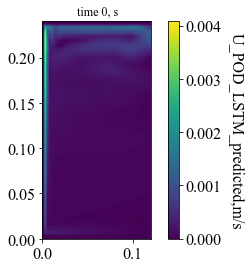

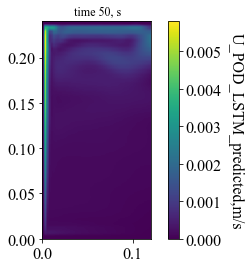

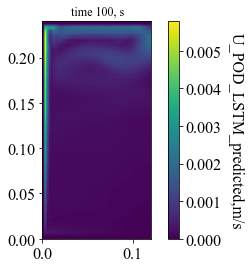

In [103]:
for i in range(0,Ureconstructed_LSTM.shape[1],50):
    print(i)
    plt.figure(i,facecolor=(1, 1, 1))
    v=Ureconstructed_LSTM[:,i]
    zi = scipy.interpolate.griddata((x,y),v,(xi,yi),method="cubic")
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'
    plt.imshow(zi, vmin=v.min(), vmax=v.max(), origin="lower", extent=[x.min(), x.max(), y.min(), y.max()])
    plt.title(" time %i, s" %i, fontsize=12)
    cba=plt.colorbar()
#    cbar = plt.colorbar(heatmap)
    #cbar.ax.set_yticklabels(['0','1','2','>3'])
    cba.set_label('U_POD_LSTM_predicted,m/s', rotation=270,labelpad=22)

    plt.savefig('U_POD_LSTM_predicted'+str(i)+'.png')
    del v,zi

0
50
100


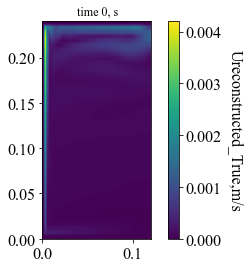

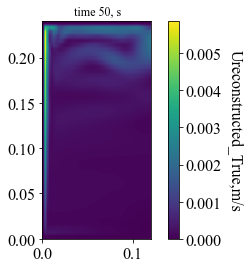

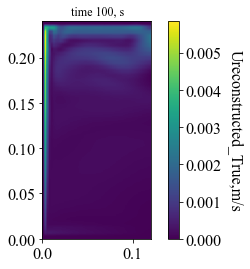

In [106]:
for i in range(0,Ureconstructed_true.shape[1],50):
    print(i)
    plt.figure(i,facecolor=(1, 1, 1))
    v=Ureconstructed_true[:,i]
    zi = scipy.interpolate.griddata((x,y),v,(xi,yi),method="cubic")
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'
    plt.imshow(zi, vmin=v.min(), vmax=v.max(), origin="lower", extent=[x.min(), x.max(), y.min(), y.max()])
    
    plt.title(" time %i, s" %i, fontsize=12)
    cba=plt.colorbar()
#    cbar = plt.colorbar(heatmap)
    #cbar.ax.set_yticklabels(['0','1','2','>3'])
    cba.set_label('Ureconstructed_True,m/s', rotation=270,labelpad=22)

    
    #plt.colorbar()
    plt.savefig('Ureconstructed_True'+str(i)+'.png')
    del v,zi

0
50
100


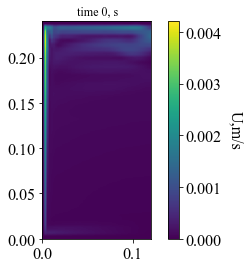

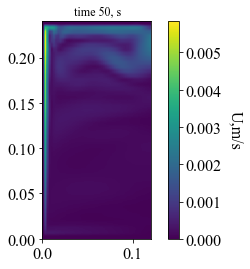

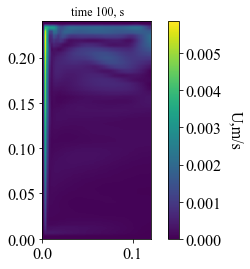

In [107]:
for i in range(0,U[:,timeindex_test_label].shape[1],50):
    print(i)
    plt.figure(i,facecolor=(1, 1, 1))
    v=U[:,timeindex_test_label][:,i]
    zi = scipy.interpolate.griddata((x,y),v,(xi,yi),method="cubic")
    matplotlib.rcParams['xtick.direction'] = 'out'
    matplotlib.rcParams['ytick.direction'] = 'out'
    plt.imshow(zi, vmin=v.min(), vmax=v.max(), origin="lower", extent=[x.min(), x.max(), y.min(), y.max()])
    
    plt.title(" time %i, s" %i, fontsize=12)
    cba=plt.colorbar()
#    cbar = plt.colorbar(heatmap)
    #cbar.ax.set_yticklabels(['0','1','2','>3'])
    cba.set_label('U,m/s', rotation=270,labelpad=22)

    
    #plt.colorbar()
    plt.savefig('U_'+str(i)+'.png')
    del v,zi

In [2]:
# Snippets from code below on different ways of using LSTM. The source of this code are in reference below.

trials = study.best_trial
print("Best Score: ", trials.value)
print("Best Params: ")
for key, value in trials.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
#Convert into LSTM format with Input: num_samples x times at time t,t-1,t-2 x feature , and Output: num_samples (value at time t) 

In [3]:
# For one file. Loading and checking. 